In [1]:
import pandas as pd
import numpy as np

#First I want to create a dataset from the provided values, and incrementally change it to improve it until we come to a realistic and detailed dataset fit to the provided information in the prompt to use for analysis on this dynamic situation Lyft faces.

In [3]:
# Initialize data
take_rates = np.arange(3.0, 6.5, 0.5)
fare = 25
base_match_rate = {3: 93, 6: 60}  # Match rates for $3 and $6
base_driver_churn = {3: 3.5, 6: 5}  # Driver churn rates for $3 and $6
base_rider_churn = {93: 10, 60: 33}  # Rider churn rates based on match rate
operational_cost_per_ride = 2  # Estimated operational cost per completed ride

# Interpolate match rates and churn rates
match_rates = np.interp(take_rates, [3, 6], [93, 60])
driver_churn = np.interp(take_rates, [3, 6], [3.5, 5])
rider_churn = np.interp(match_rates, [93, 60], [10, 33])

# Initialize DataFrame
data = {
    "Lyft Take Rate ($)": take_rates,
    "Driver Payout ($)": fare - take_rates,
    "Match Rate (%)": match_rates,
    "Driver Churn (%)": driver_churn,
    "Rider Churn (%)": rider_churn,
}

df = pd.DataFrame(data)

# Calculate derived metrics
df["Completed Rides"] = 100 * (df["Match Rate (%)"] / 100)  # Example: 100 ride requests
df["Driver Churn Cost ($)"] = df["Driver Churn (%)"] / 100 * 100 * 500  # CAC per driver
df["Rider Churn Cost ($)"] = df["Rider Churn (%)"] / 100 * 100 * 15  # CAC per rider
df["Churn Costs ($)"] = df["Driver Churn Cost ($)"] + df["Rider Churn Cost ($)"]
df["Net Revenue ($)"] = df["Completed Rides"] * df["Lyft Take Rate ($)"] - df["Churn Costs ($)"]
df["Net Profit ($)"] = df["Net Revenue ($)"] - (df["Completed Rides"] * operational_cost_per_ride)

# Save or Display
print(df)
df.to_csv("lyft_analysis_net_profit.csv", index=False)

   Lyft Take Rate ($)  Driver Payout ($)  Match Rate (%)  Driver Churn (%)  \
0                 3.0               22.0            93.0              3.50   
1                 3.5               21.5            87.5              3.75   
2                 4.0               21.0            82.0              4.00   
3                 4.5               20.5            76.5              4.25   
4                 5.0               20.0            71.0              4.50   
5                 5.5               19.5            65.5              4.75   
6                 6.0               19.0            60.0              5.00   

   Rider Churn (%)  Completed Rides  Driver Churn Cost ($)  \
0             33.0             93.0                 1750.0   
1             33.0             87.5                 1875.0   
2             33.0             82.0                 2000.0   
3             33.0             76.5                 2125.0   
4             33.0             71.0                 2250.0   
5  

#Quickly I am able to set up a basic dataset for hte situation, now I want to iteratively improve it. 

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Data points
match_rates = np.array([60, 93]).reshape(-1, 1)  # Match rates (independent variable)
rider_churn = np.array([33, 10])  # Churn rates (dependent variable)

# Fit linear regression model
model = LinearRegression()
model.fit(match_rates, rider_churn)

# Coefficients
a = model.coef_[0]  # Slope
b = model.intercept_  # Intercept

# Print the equation of the line
print(f"Rider Churn Rate = {a:.2f} * Match Rate + {b:.2f}")

# Predict churn rates for all match rates in the dataset
predicted_churn = model.predict(np.arange(60, 94, 1).reshape(-1, 1))

# Example: Generate match rates from 60% to 93% (or use actual data)
df = pd.DataFrame({
    "Match Rate (%)": np.arange(60, 94, 1),
    "Predicted Rider Churn (%)": predicted_churn
})

# Save the results for visualization or further analysis
print(df.head())
df.to_csv("predicted_rider_churn.csv", index=False)


Rider Churn Rate = -0.70 * Match Rate + 74.82
   Match Rate (%)  Predicted Rider Churn (%)
0              60                  33.000000
1              61                  32.303030
2              62                  31.606061
3              63                  30.909091
4              64                  30.212121


/Users/brendanbrady/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


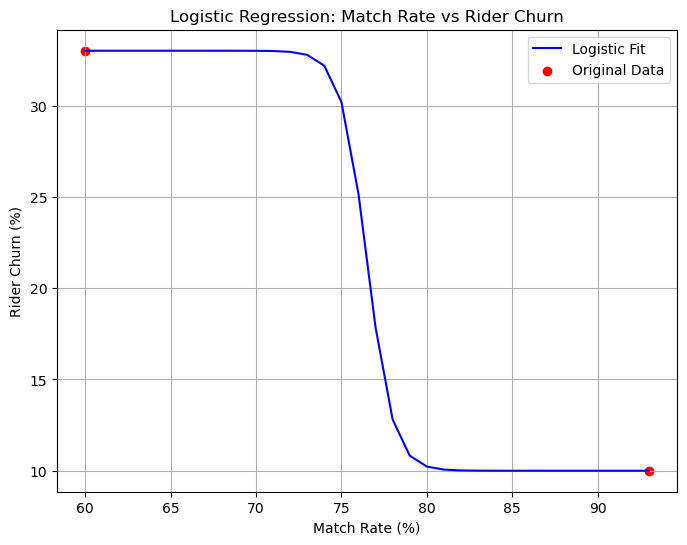

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  33.000000
2               62                  33.000000
3               63                  33.000000
4               64                  32.999998
5               65                  32.999994
6               66                  32.999977
7               67                  32.999915
8               68                  32.999683
9               69                  32.998818
10              70                  32.995590
11              71                  32.983552
12              72                  32.938744
13              73                  32.773080
14              74                  32.175492
15              75                  30.197812
16              76                  25.154675
17              77                  17.845325
18              78                  12.802188
19              79                  10.824508
20              80                

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data points
match_rates = np.array([60, 93])  # Match rates
rider_churn = np.array([33, 10])  # Churn rates

# Define logistic function
def logistic(x, a, b):
    return 33 - (33 - 10) / (1 + np.exp(-(a * (x - 76.5))))  # Centered sigmoid around mean

# Fit logistic model
params, _ = curve_fit(logistic, match_rates, rider_churn)
a, b = params

# Predict churn rates for match rates between 60% and 93%
x_values = np.arange(60, 94)  # Match rates to predict
predicted_churn = logistic(x_values, a, b)

# Create a DataFrame for results
df = pd.DataFrame({
    "Match Rate (%)": x_values,
    "Predicted Rider Churn (%)": predicted_churn
})

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_values, predicted_churn, label="Logistic Fit", color="blue")
plt.scatter(match_rates, rider_churn, color="red", label="Original Data")
plt.title("Logistic Regression: Match Rate vs Rider Churn")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("logistic_rider_churn_corrected.csv", index=False)


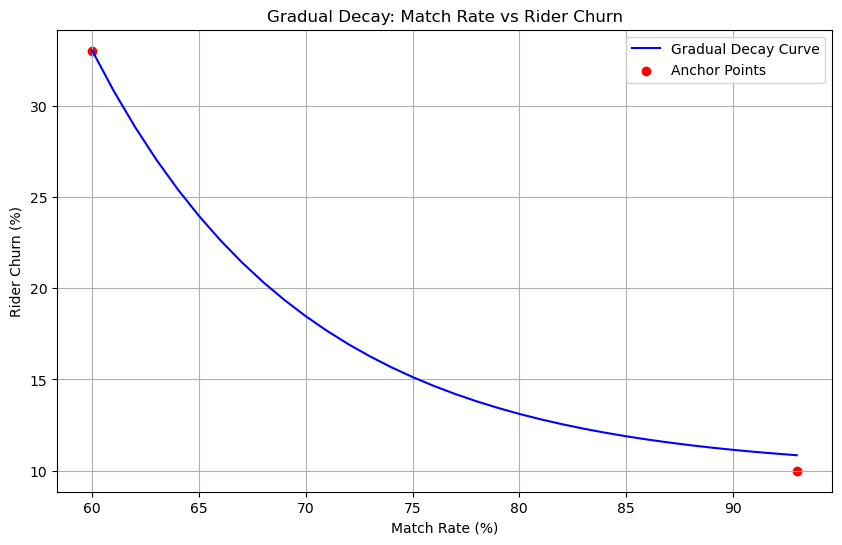

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  30.811261
2               62                  28.830807
3               63                  27.038819
4               64                  25.417361
5               65                  23.950205
6               66                  22.622668
7               67                  21.421462
8               68                  20.334566
9               69                  19.351102
10              70                  18.461227
11              71                  17.656035
12              72                  16.927467
13              73                  16.268231
14              74                  15.671730
15              75                  15.131994
16              76                  14.643620
17              77                  14.201721
18              78                  13.801874
19              79                  13.440078
20              80                

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data points (manually defined for smooth transition)
match_rates = np.arange(60, 94)  # Match rates
churn_start = 33  # Starting churn rate at 60% match rate
churn_end = 10  # Ending churn rate at 93% match rate

# Gradual decay function (exponential smoothing)
def gradual_decay(x, start, end, rate):
    return end + (start - end) * np.exp(-rate * (x - x[0]))

# Adjust decay rate for smoother transition
decay_rate = 0.1  # Lower rate for more gradual change
predicted_churn = gradual_decay(match_rates, churn_start, churn_end, decay_rate)

# Create DataFrame
df = pd.DataFrame({
    "Match Rate (%)": match_rates,
    "Predicted Rider Churn (%)": np.round(predicted_churn, 6)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(match_rates, predicted_churn, label="Gradual Decay Curve", color="blue")
plt.scatter([60, 93], [33, 10], color="red", label="Anchor Points")
plt.title("Gradual Decay: Match Rate vs Rider Churn")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save or display results
print(df)
df.to_csv("gradual_decay_rider_churn.csv", index=False)




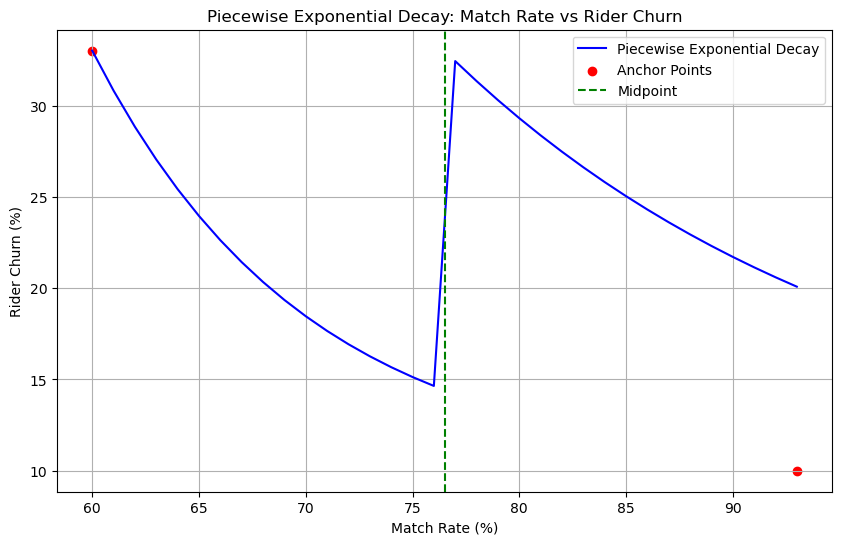

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  30.811261
2               62                  28.830807
3               63                  27.038819
4               64                  25.417361
5               65                  23.950205
6               66                  22.622668
7               67                  21.421462
8               68                  20.334566
9               69                  19.351102
10              70                  18.461227
11              71                  17.656035
12              72                  16.927467
13              73                  16.268231
14              74                  15.671730
15              75                  15.131994
16              76                  14.643620
17              77                  32.432128
18              78                  31.338100
19              79                  30.297429
20              80                

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data points
match_rates = np.arange(60, 94)  # Match rates
churn_start = 33  # Starting churn rate at 60% match rate
churn_end = 10  # Ending churn rate at 93% match rate

# Define piecewise exponential decay function
def piecewise_decay(x, start, end, mid, rate1, rate2):
    """Applies different decay rates before and after a midpoint."""
    decay = np.zeros_like(x, dtype=float)
    for i, val in enumerate(x):
        if val <= mid:
            decay[i] = end + (start - end) * np.exp(-rate1 * (val - x[0]))
        else:
            decay[i] = end + (start - end) * np.exp(-rate2 * (val - mid))
    return decay

# Parameters for the decay
mid_point = 76.5  # Midpoint of the match rate range
rate1 = 0.1  # Decay rate for match rates <= midpoint
rate2 = 0.05  # Decay rate for match rates > midpoint

# Calculate churn rates
predicted_churn = piecewise_decay(match_rates, churn_start, churn_end, mid_point, rate1, rate2)

# Create DataFrame
df = pd.DataFrame({
    "Match Rate (%)": match_rates,
    "Predicted Rider Churn (%)": np.round(predicted_churn, 6)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(match_rates, predicted_churn, label="Piecewise Exponential Decay", color="blue")
plt.scatter([60, 93], [33, 10], color="red", label="Anchor Points")
plt.axvline(mid_point, color="green", linestyle="--", label="Midpoint")
plt.title("Piecewise Exponential Decay: Match Rate vs Rider Churn")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save or display results
print(df)
df.to_csv("piecewise_decay_rider_churn.csv", index=False)


/Users/brendanbrady/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


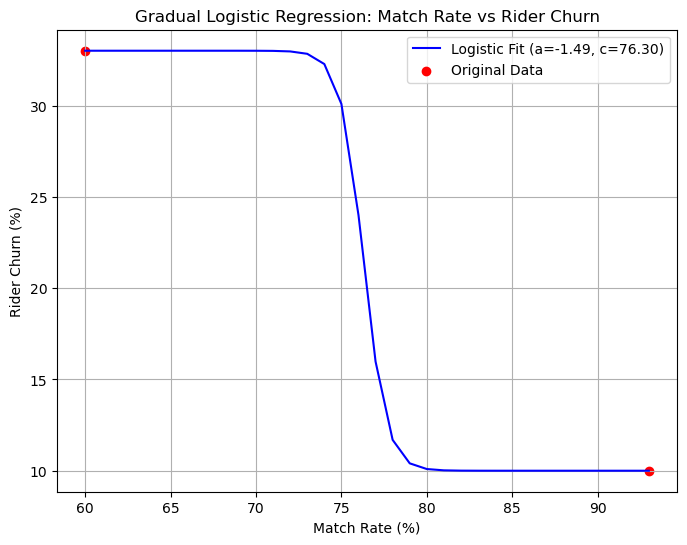

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  33.000000
2               62                  33.000000
3               63                  33.000000
4               64                  33.000000
5               65                  32.999999
6               66                  32.999995
7               67                  32.999977
8               68                  32.999900
9               69                  32.999558
10              70                  32.998042
11              71                  32.991330
12              72                  32.961644
13              73                  32.831068
14              74                  32.270094
15              75                  30.084202
16              76                  23.998152
17              77                  15.976327
18              78                  11.688990
19              79                  10.404288
20              80                

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data points
match_rates = np.array([60, 93])  # Match rates
rider_churn = np.array([33, 10])  # Churn rates

# Define logistic function
def logistic(x, a, c):
    return 10 + (33 - 10) / (1 + np.exp(-a * (x - c)))  # Gradual logistic curve

# Fit logistic model
params, _ = curve_fit(logistic, match_rates, rider_churn, p0=[0.1, 76.5])  # Start with lower steepness (a)
a, c = params

# Predict churn rates for match rates between 60% and 93%
x_values = np.arange(60, 94)  # Match rates to predict
predicted_churn = logistic(x_values, a, c)

# Create a DataFrame for results
df = pd.DataFrame({
    "Match Rate (%)": x_values,
    "Predicted Rider Churn (%)": predicted_churn
})

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_values, predicted_churn, label=f"Logistic Fit (a={a:.2f}, c={c:.2f})", color="blue")
plt.scatter(match_rates, rider_churn, color="red", label="Original Data")
plt.title("Gradual Logistic Regression: Match Rate vs Rider Churn")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("gradual_logistic_rider_churn.csv", index=False)


/Users/brendanbrady/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


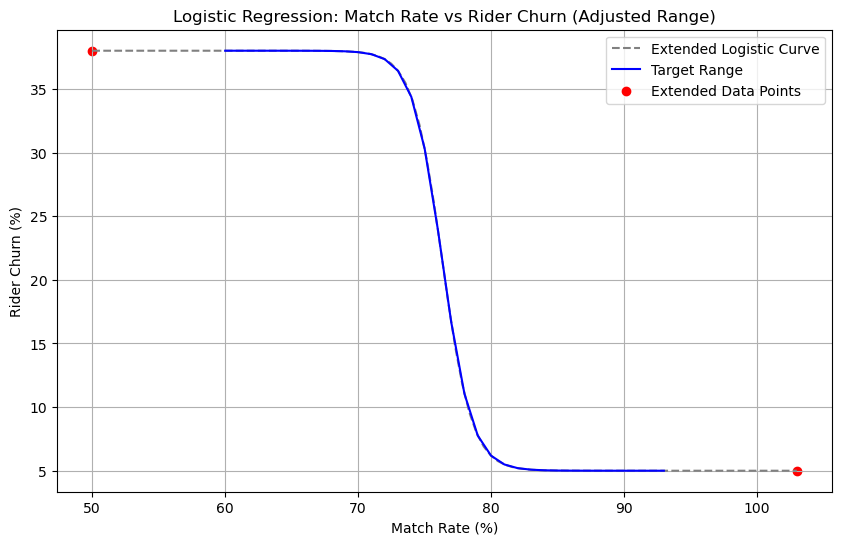

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  37.999986
1               61                  37.999965
2               62                  37.999915
3               63                  37.999791
4               64                  37.999487
5               65                  37.998740
6               66                  37.996909
7               67                  37.992416
8               68                  37.981394
9               69                  37.954379
10              70                  37.888270
11              71                  37.727156
12              72                  37.338391
13              73                  36.422393
14              74                  34.380149
15              75                  30.338761
16              76                  23.943989
17              77                  16.698716
18              78                  11.034757
19              79                   7.757969
20              80                

In [21]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data points
extended_match_rates = np.array([50, 103])  # Extended match rates
extended_rider_churn = np.array([38, 5])  # Extended churn rates

# Define logistic function
def logistic(x, a, c):
    return 5 + (38 - 5) / (1 + np.exp(-a * (x - c)))

# Fit logistic model
initial_guess = [0.1, 76.5]  # Steepness and center point
params, _ = curve_fit(logistic, extended_match_rates, extended_rider_churn, p0=initial_guess)
a, c = params

# Predict churn rates for the extended and target ranges
x_extended = np.linspace(50, 103, 100)  # Extended range for smooth curve
x_target = np.arange(60, 94)  # Original match rate range
predicted_churn_extended = logistic(x_extended, a, c)
predicted_churn_target = logistic(x_target, a, c)

# Create a DataFrame for the target range
df = pd.DataFrame({
    "Match Rate (%)": x_target,
    "Predicted Rider Churn (%)": predicted_churn_target
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_extended, predicted_churn_extended, label="Extended Logistic Curve", color="gray", linestyle="--")
plt.plot(x_target, predicted_churn_target, label="Target Range", color="blue")
plt.scatter(extended_match_rates, extended_rider_churn, color="red", label="Extended Data Points")
plt.title("Logistic Regression: Match Rate vs Rider Churn (Adjusted Range)")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("logistic_rider_churn_adjusted.csv", index=False)


/Users/brendanbrady/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


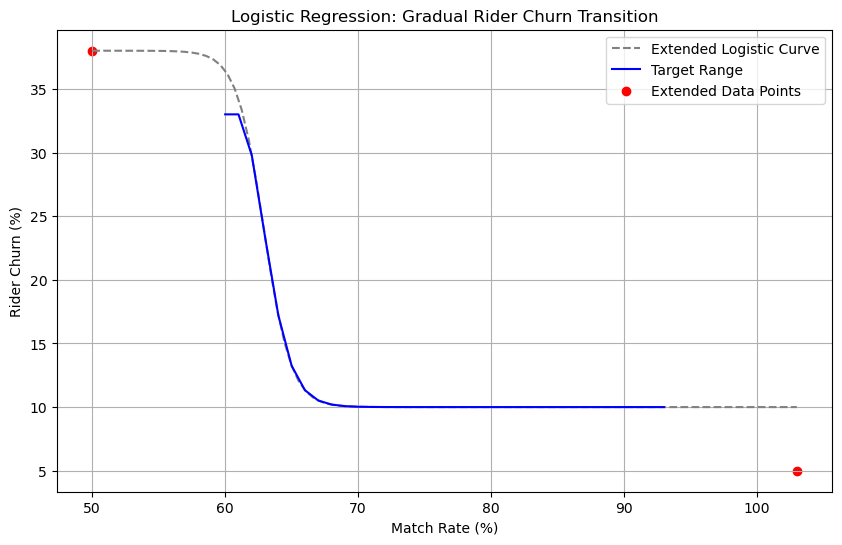

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  33.000000
2               62                  29.790672
3               63                  23.366269
4               64                  17.198623
5               65                  13.245712
6               66                  11.325146
7               67                  10.517278
8               68                  10.198261
9               69                  10.075449
10              70                  10.028634
11              71                  10.010856
12              72                  10.004114
13              73                  10.001559
14              74                  10.000591
15              75                  10.000224
16              76                  10.000085
17              77                  10.000032
18              78                  10.000012
19              79                  10.000005
20              80                

In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data points (extended for gradual decay)
extended_match_rates = np.array([50, 103])  # Extended match rates
extended_rider_churn = np.array([38, 5])  # Extended churn rates

# Define logistic function
def logistic(x, a, c):
    return 10 + (38 - 10) / (1 + np.exp(-a * (x - c)))

# Fit logistic model with bounds
initial_guess = [0.03, 76.5]  # Lower steepness and center point for gradual transition
params, _ = curve_fit(logistic, extended_match_rates, extended_rider_churn, p0=initial_guess)
a, c = params

# Predict churn rates for extended and target ranges
x_extended = np.linspace(50, 103, 100)  # Extended range for smooth curve
x_target = np.arange(60, 94)  # Original match rate range
predicted_churn_extended = logistic(x_extended, a, c)
predicted_churn_target = logistic(x_target, a, c)

# Apply precision adjustment for gradual decay
predicted_churn_target = np.clip(predicted_churn_target, 10, 33)  # Ensure limits
predicted_churn_target = np.round(predicted_churn_target, 6)  # Match desired precision

# Create a DataFrame for the target range
df = pd.DataFrame({
    "Match Rate (%)": x_target,
    "Predicted Rider Churn (%)": predicted_churn_target
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_extended, predicted_churn_extended, label="Extended Logistic Curve", color="gray", linestyle="--")
plt.plot(x_target, predicted_churn_target, label="Target Range", color="blue")
plt.scatter(extended_match_rates, extended_rider_churn, color="red", label="Extended Data Points")
plt.title("Logistic Regression: Gradual Rider Churn Transition")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("gradual_rider_churn_final.csv", index=False)


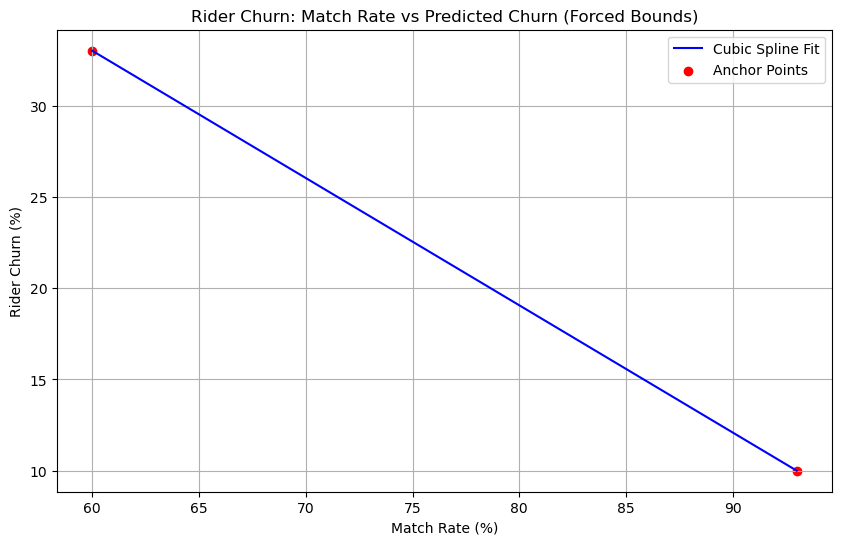

    Match Rate (%)  Predicted Rider Churn (%)
0             60.0                  33.000000
1             61.0                  32.303030
2             62.0                  31.606061
3             63.0                  30.909091
4             64.0                  30.212121
5             65.0                  29.515152
6             66.0                  28.818182
7             67.0                  28.121212
8             68.0                  27.424242
9             69.0                  26.727273
10            70.0                  26.030303
11            71.0                  25.333333
12            72.0                  24.636364
13            73.0                  23.939394
14            74.0                  23.242424
15            75.0                  22.545455
16            76.0                  21.848485
17            77.0                  21.151515
18            78.0                  20.454545
19            79.0                  19.757576
20            80.0                

In [27]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Define the anchor points
match_rates = [60, 93]  # Exact match rates at boundaries
churn_rates = [33, 10]  # Exact churn rates at boundaries

# Generate additional points for a smooth curve
intermediate_match_rates = np.linspace(60, 93, 34)  # Includes the range 60–93 evenly spaced

# Fit cubic spline interpolation
cubic_spline = CubicSpline(match_rates, churn_rates)

# Predict churn rates for intermediate match rates
predicted_churn_rates = cubic_spline(intermediate_match_rates)

# Force boundary values to ensure they match exactly
predicted_churn_rates[0] = churn_rates[0]  # 33 at match rate = 60
predicted_churn_rates[-1] = churn_rates[-1]  # 10 at match rate = 93

# Create a DataFrame
df = pd.DataFrame({
    "Match Rate (%)": intermediate_match_rates,
    "Predicted Rider Churn (%)": np.round(predicted_churn_rates, 6)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(intermediate_match_rates, predicted_churn_rates, label="Cubic Spline Fit", color="blue")
plt.scatter(match_rates, churn_rates, color="red", label="Anchor Points")
plt.title("Rider Churn: Match Rate vs Predicted Churn (Forced Bounds)")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("forced_bounds_rider_churn.csv", index=False)


/var/folders/6g/9_rtgwc16kq0vxq3xkt1ln500000gn/T/ipykernel_60223/2777033407.py:7: RuntimeWarning: overflow encountered in exp
  return 34 - (34 - 9) / (1 + np.exp(-(a * (x - 76.5))))  # Centered sigmoid around mean
/Users/brendanbrady/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


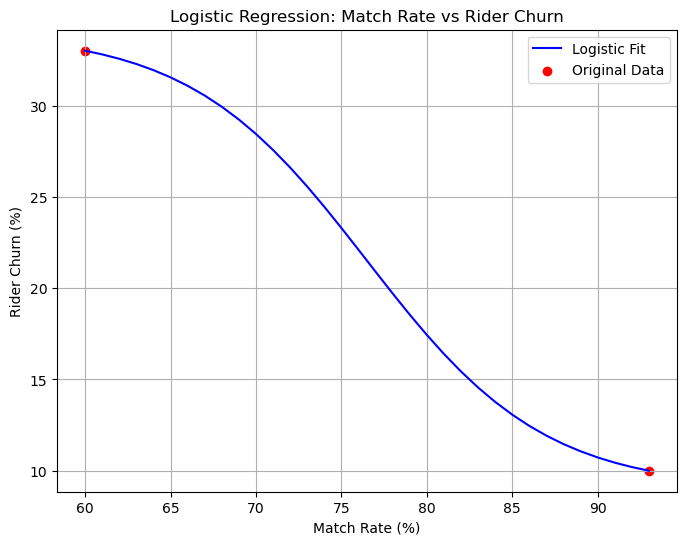

    Match Rate (%)  Predicted Rider Churn (%)
0               60                  33.000000
1               61                  32.797805
2               62                  32.557186
3               63                  32.271903
4               64                  31.935157
5               65                  31.539727
6               66                  31.078218
7               67                  30.543413
8               68                  29.928769
9               69                  29.229033
10              70                  28.440977
11              71                  27.564164
12              72                  26.601683
13              73                  25.560698
14              74                  24.452688
15              75                  23.293256
16              76                  22.101439
17              77                  20.898561
18              78                  19.706744
19              79                  18.547312
20              80                

In [32]:
# Data points
match_rates = np.array([60, 93])  # Match rates
rider_churn = np.array([33, 10])  # Churn rates

# Define logistic function
def logistic(x, a, b):
    return 34 - (34 - 9) / (1 + np.exp(-(a * (x - 76.5))))  # Centered sigmoid around mean

# Fit logistic model
params, _ = curve_fit(logistic, match_rates, rider_churn)
a, b = params

# Predict churn rates for match rates between 60% and 93%
x_values = np.arange(60, 94)  # Match rates to predict
predicted_churn = logistic(x_values, a, b)

# Create a DataFrame for results
df = pd.DataFrame({
    "Match Rate (%)": x_values,
    "Predicted Rider Churn (%)": predicted_churn
})

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_values, predicted_churn, label="Logistic Fit", color="blue")
plt.scatter(match_rates, rider_churn, color="red", label="Original Data")
plt.title("Logistic Regression: Match Rate vs Rider Churn")
plt.xlabel("Match Rate (%)")
plt.ylabel("Rider Churn (%)")
plt.legend()
plt.grid()
plt.show()

# Save the DataFrame
print(df)
df.to_csv("logistic_rider_churn_corrected.csv", index=False)

#As you can see above I spent some time analyzing trends for rider churn. I am making assumptions so I wanted to explore my options and found what I htought was a realistic logistical curve (some other decent ones with the gradual and linear). I later realized, shown in the next Notebook, I was wrong to assume a trend and should use the provided data to make an equation. However I was able to use this logic in elsewhere, so the analysis was still useful.

In [34]:
# Additional parameters
lyft_take_rates = np.arange(3, 6.5, 0.5)  # Lyft take rates ($3-$6)
completed_rides = predicted_churn / 100 * 100  # Assuming 100 ride requests
driver_cac = 500  # Average CAC per driver
rider_cac = 15  # Average CAC per rider
operational_cost_per_ride = 2  # Operational cost per completed ride

# Calculate derived metrics
data = []
for take_rate in lyft_take_rates:
    driver_payout = 25 - take_rate
    net_revenue = []
    net_profit = []
    
    for churn, match_rate in zip(predicted_churn, x_values):
        # Calculate churn costs
        churn_cost = (churn / 100) * rider_cac * completed_rides.sum()
        # Calculate revenue
        revenue = completed_rides.sum() * take_rate
        profit = revenue - churn_cost - (completed_rides.sum() * operational_cost_per_ride)
        net_revenue.append(revenue)
        net_profit.append(profit)
        
        data.append({
            "Lyft Take Rate ($)": take_rate,
            "Driver Payout ($)": driver_payout,
            "Match Rate (%)": match_rate,
            "Rider Churn (%)": churn,
            "Completed Rides": completed_rides.sum(),
            "Net Revenue ($)": revenue,
            "Net Profit ($)": profit
        })

df_results = pd.DataFrame(data)

# Save and display results
print(df_results)
df_results.to_csv("lyft_analysis_results.csv", index=False)


     Lyft Take Rate ($)  Driver Payout ($)  Match Rate (%)  Rider Churn (%)  \
0                   3.0               22.0              60        33.000000   
1                   3.0               22.0              61        32.797805   
2                   3.0               22.0              62        32.557186   
3                   3.0               22.0              63        32.271903   
4                   3.0               22.0              64        31.935157   
..                  ...                ...             ...              ...   
233                 6.0               19.0              89        11.064843   
234                 6.0               19.0              90        10.728097   
235                 6.0               19.0              91        10.442814   
236                 6.0               19.0              92        10.202195   
237                 6.0               19.0              93        10.000000   

     Completed Rides  Net Revenue ($)  Net Profit (

In [36]:
# Additional parameters
lyft_take_rates = np.arange(3, 6.5, 0.5)  # Lyft take rates ($3-$6)
completed_rides = predicted_churn / 100 * 100  # Assuming 100 ride requests
driver_cac = 500  # Average CAC per driver
rider_cac = 15  # Average CAC per rider
operational_cost_per_ride = 2  # Operational cost per completed ride

# Baseline driver churn values
driver_churn_baseline = {6: 5.0, 3: 3.5}  # Churn at $6 and $3 take rates
driver_churn_slope = (driver_churn_baseline[6] - driver_churn_baseline[3]) / (6 - 3)

# Calculate driver churn for each Lyft take rate
def calculate_driver_churn(take_rate):
    return driver_churn_baseline[6] - driver_churn_slope * (6 - take_rate)

# Create dataset
data = []
for take_rate in lyft_take_rates:
    driver_payout = 25 - take_rate
    driver_churn = calculate_driver_churn(take_rate)
    
    for churn, match_rate in zip(predicted_churn, x_values):
        # Calculate churn costs
        rider_churn_cost = (churn / 100) * rider_cac * completed_rides.sum()
        driver_churn_cost = (driver_churn / 100) * driver_cac * completed_rides.sum() / 100  # Per driver cost
        total_churn_cost = rider_churn_cost + driver_churn_cost

        # Calculate revenue and profit
        revenue = completed_rides.sum() * take_rate
        profit = revenue - total_churn_cost - (completed_rides.sum() * operational_cost_per_ride)
        
        data.append({
            "Lyft Take Rate ($)": take_rate,
            "Driver Payout ($)": driver_payout,
            "Driver Churn (%)": driver_churn,
            "Rider Churn (%)": churn,
            "Match Rate (%)": match_rate,
            "Completed Rides": completed_rides.sum(),
            "Rider Churn Cost ($)": rider_churn_cost,
            "Driver Churn Cost ($)": driver_churn_cost,
            "Total Churn Cost ($)": total_churn_cost,
            "Net Revenue ($)": revenue,
            "Net Profit ($)": profit
        })

df_results = pd.DataFrame(data)

# Save and display results
print(df_results)
df_results.to_csv("lyft_analysis_with_driver_churn.csv", index=False)


     Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  Rider Churn (%)  \
0                   3.0               22.0               3.5        33.000000   
1                   3.0               22.0               3.5        32.797805   
2                   3.0               22.0               3.5        32.557186   
3                   3.0               22.0               3.5        32.271903   
4                   3.0               22.0               3.5        31.935157   
..                  ...                ...               ...              ...   
233                 6.0               19.0               5.0        11.064843   
234                 6.0               19.0               5.0        10.728097   
235                 6.0               19.0               5.0        10.442814   
236                 6.0               19.0               5.0        10.202195   
237                 6.0               19.0               5.0        10.000000   

     Match Rate (%)  Comple

#Next I want to provide a real-world view of the situation and did some market research to find the number of rides we can expect at this airport. 

/var/folders/6g/9_rtgwc16kq0vxq3xkt1ln500000gn/T/ipykernel_60223/3445219765.py:12: RuntimeWarning: divide by zero encountered in log
  k = -np.log(1 - (end_share - start_share) / (end_share - start_share)) / 12


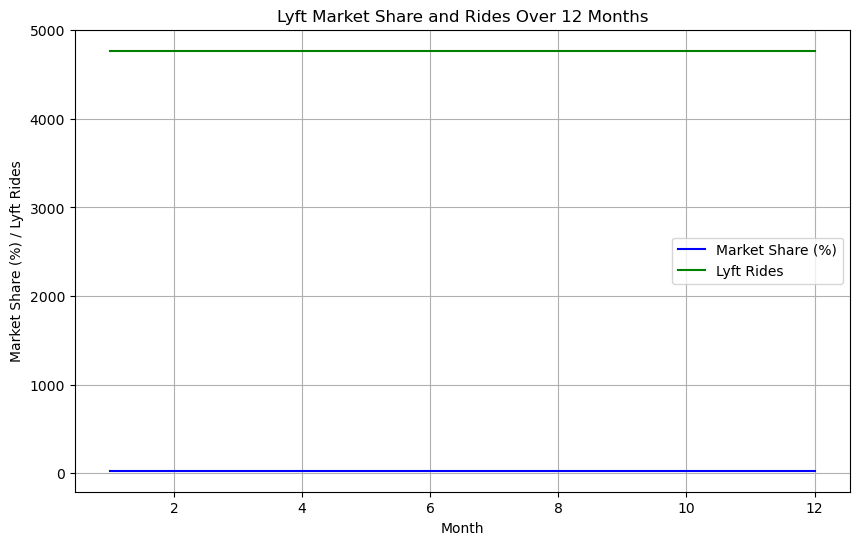

    Month  Market Share (%)  Lyft Rides
0       1              29.0      4768.0
1       2              29.0      4768.0
2       3              29.0      4768.0
3       4              29.0      4768.0
4       5              29.0      4768.0
5       6              29.0      4768.0
6       7              29.0      4768.0
7       8              29.0      4768.0
8       9              29.0      4768.0
9      10              29.0      4768.0
10     11              29.0      4768.0
11     12              29.0      4768.0


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
total_monthly_rides = 16440  # Total rideshare trips per month (548 daily x 30)
start_share = 0.05  # 5% market share in Month 1
end_share = 0.29  # 29% market share in Month 12
months = np.arange(1, 13)  # Month 1 to Month 12

# Calculate the growth rate constant (k)
k = -np.log(1 - (end_share - start_share) / (end_share - start_share)) / 12

# Calculate market share dynamically for each month
market_share = start_share + (end_share - start_share) * (1 - np.exp(-k * months))

# Calculate Lyft rides for each month
lyft_rides = market_share * total_monthly_rides

# Create a DataFrame
df_rides = pd.DataFrame({
    "Month": months,
    "Market Share (%)": np.round(market_share * 100, 2),
    "Lyft Rides": np.round(lyft_rides, 0)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(months, market_share * 100, label="Market Share (%)", color="blue")
plt.plot(months, lyft_rides, label="Lyft Rides", color="green")
plt.title("Lyft Market Share and Rides Over 12 Months")
plt.xlabel("Month")
plt.ylabel("Market Share (%) / Lyft Rides")
plt.legend()
plt.grid()
plt.show()

# Save and display results
print(df_rides)
df_rides.to_csv("debugged_lyft_rideshare_growth.csv", index=False)




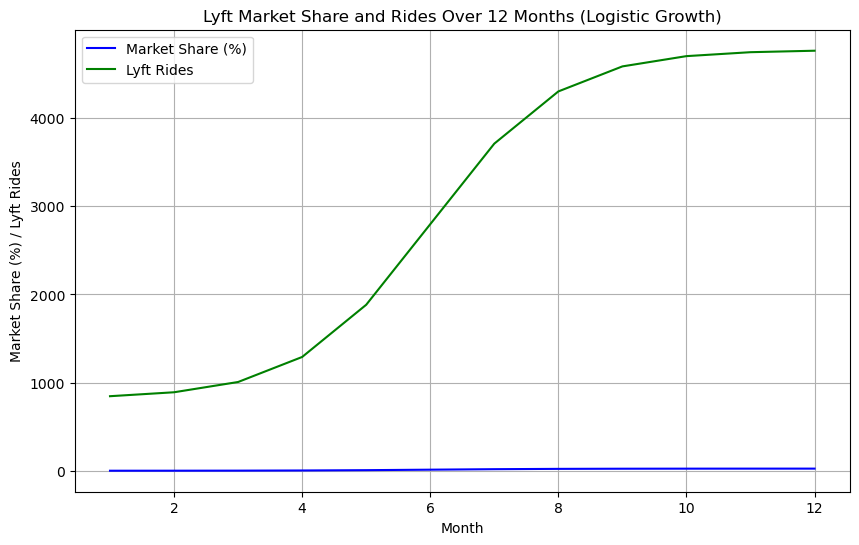

    Month  Market Share (%)  Lyft Rides
0       1              5.16       848.0
1       2              5.43       893.0
2       3              6.14      1009.0
3       4              7.86      1292.0
4       5             11.45      1883.0
5       6             17.00      2795.0
6       7             22.55      3706.0
7       8             26.14      4297.0
8       9             27.86      4580.0
9      10             28.57      4697.0
10     11             28.84      4741.0
11     12             28.94      4758.0


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
total_monthly_rides = 16440  # Total rideshare trips per month (548 daily x 30)
start_share = 0.05  # 5% initial market share
end_share = 0.29  # 29% maximum market share
months = np.arange(1, 13)  # Month 1 to Month 12
t_mid = 6  # Midpoint of the growth curve
k = 1  # Growth rate (adjustable for steepness)

# Logistic growth function
def logistic_growth(t, S_max, S_min, t_mid, k):
    return S_min + (S_max - S_min) / (1 + np.exp(-k * (t - t_mid)))

# Calculate market share and Lyft rides
market_share = logistic_growth(months, end_share, start_share, t_mid, k)
lyft_rides = market_share * total_monthly_rides

# Create DataFrame
df_rides = pd.DataFrame({
    "Month": months,
    "Market Share (%)": np.round(market_share * 100, 2),
    "Lyft Rides": np.round(lyft_rides, 0)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(months, market_share * 100, label="Market Share (%)", color="blue")
plt.plot(months, lyft_rides, label="Lyft Rides", color="green")
plt.title("Lyft Market Share and Rides Over 12 Months (Logistic Growth)")
plt.xlabel("Month")
plt.ylabel("Market Share (%) / Lyft Rides")
plt.legend()
plt.grid()
plt.show()

# Display and save results
print(df_rides)
df_rides.to_csv("logistic_growth_lyft_rideshare.csv", index=False)


In [ ]:
#A little debugging and I got it. 

In [44]:
# Base dataset from earlier analysis (e.g., df_results)
# Assuming df_results already exists and contains key columns: Lyft Take Rate, Driver Churn (%), Rider Churn (%)

# Monthly ride data from logistic growth
monthly_rides = df_rides["Lyft Rides"].values  # Extract monthly rides
months = df_rides["Month"].values

# Expand the dataset for 12 months
expanded_data = []
for month, rides in zip(months, monthly_rides):
    for _, row in df_results.iterrows():
        # Update completed rides and recalculate metrics
        completed_rides = rides  # Use monthly rides for completed rides
        rider_churn_cost = (row["Rider Churn (%)"] / 100) * 15 * completed_rides  # Rider churn cost
        driver_churn_cost = (row["Driver Churn (%)"] / 100) * 500 * completed_rides / 100  # Driver churn cost
        total_churn_cost = rider_churn_cost + driver_churn_cost

        # Calculate net revenue and net profit
        revenue = completed_rides * row["Lyft Take Rate ($)"]
        profit = revenue - total_churn_cost - (completed_rides * 2)  # Subtract operational costs

        # Append updated row with month-specific data
        expanded_data.append({
            "Month": month,
            "Lyft Take Rate ($)": row["Lyft Take Rate ($)"],
            "Driver Payout ($)": row["Driver Payout ($)"],
            "Driver Churn (%)": row["Driver Churn (%)"],
            "Rider Churn (%)": row["Rider Churn (%)"],
            "Match Rate (%)": row["Match Rate (%)"],
            "Completed Rides": completed_rides,
            "Rider Churn Cost ($)": rider_churn_cost,
            "Driver Churn Cost ($)": driver_churn_cost,
            "Total Churn Cost ($)": total_churn_cost,
            "Net Revenue ($)": revenue,
            "Net Profit ($)": profit
        })

# Create final expanded dataset
df_final = pd.DataFrame(expanded_data)

# Save and display results
print(df_final)
df_final.to_csv("final_lyft_analysis.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000            60.0            848.0 

#Now I want to expand the datset to include as many realistic examples and insights into the impacts of all lyft payouts, throughout the whole year. It is a dynamic situation, so expanding the data allows us to address just that. 

In [46]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Data for logistic regression
take_rates = np.array([3, 4, 5, 6])  # Lyft take rates ($)
match_rates = np.array([60, 70, 80, 90])  # Observed match rates (%)

# Fit logistic regression model
logistic_model = LogisticRegression()
X = take_rates.reshape(-1, 1)  # Independent variable: Lyft take rates
y = match_rates  # Dependent variable: Match rates
logistic_model.fit(X, y)

# Predict match rates dynamically based on take rates in the dataset
df_final["Match Rate (%)"] = logistic_model.predict(df_final["Lyft Take Rate ($)"].values.reshape(-1, 1))

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save and display updated results
print(df_final)
df_final.to_csv("final_lyft_analysis_dynamic_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000              60            848.0 

In [53]:
print(df_final['Match Rate (%)'])

0       60
1       60
2       60
3       60
4       60
        ..
2851    90
2852    90
2853    90
2854    90
2855    90
Name: Match Rate (%), Length: 2856, dtype: int64


In [55]:
# Parameters for match rate adjustment
baseline_match_rate = 60  # Match rate at $3 take rate
baseline_take_rate = 3.0  # Starting take rate ($3)
match_rate_slope = 10  # Change in match rate per $1 increase in take rate

# Adjust match rate using the slope
df_final["Match Rate (%)"] = (
    baseline_match_rate + match_rate_slope * (df_final["Lyft Take Rate ($)"] - baseline_take_rate)
)

# Ensure match rates remain within bounds (e.g., 60% to 90%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=90)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save and display updated results
print(df_final)
df_final.to_csv("final_lyft_analysis_match_rate_slope.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000            60.0            848.0 

In [56]:
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final["Match Rate (%)"])

0       60.0
1       60.0
2       60.0
3       60.0
4       60.0
5       60.0
6       60.0
7       60.0
8       60.0
9       60.0
10      60.0
11      60.0
12      60.0
13      60.0
14      60.0
15      60.0
16      60.0
17      60.0
18      60.0
19      60.0
20      60.0
21      60.0
22      60.0
23      60.0
24      60.0
25      60.0
26      60.0
27      60.0
28      60.0
29      60.0
30      60.0
31      60.0
32      60.0
33      60.0
34      65.0
35      65.0
36      65.0
37      65.0
38      65.0
39      65.0
40      65.0
41      65.0
42      65.0
43      65.0
44      65.0
45      65.0
46      65.0
47      65.0
48      65.0
49      65.0
50      65.0
51      65.0
52      65.0
53      65.0
54      65.0
55      65.0
56      65.0
57      65.0
58      65.0
59      65.0
60      65.0
61      65.0
62      65.0
63      65.0
64      65.0
65      65.0
66      65.0
67      65.0
68      70.0
69      70.0
70      70.0
71      70.0
72      70.0
73      70.0
74      70.0
75      70.0
76      70.0

In [57]:
# Temporarily show all rows for the selected columns
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Lyft Take Rate ($)", "Driver Churn (%)", "Rider Churn (%)"]])


      Lyft Take Rate ($)  Driver Churn (%)  Rider Churn (%)
0                    3.0              3.50        33.000000
1                    3.0              3.50        32.797805
2                    3.0              3.50        32.557186
3                    3.0              3.50        32.271903
4                    3.0              3.50        31.935157
5                    3.0              3.50        31.539727
6                    3.0              3.50        31.078218
7                    3.0              3.50        30.543413
8                    3.0              3.50        29.928769
9                    3.0              3.50        29.229033
10                   3.0              3.50        28.440977
11                   3.0              3.50        27.564164
12                   3.0              3.50        26.601683
13                   3.0              3.50        25.560698
14                   3.0              3.50        24.452688
15                   3.0              3.

In [58]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Rider Churn (%)", "Driver Churn (%)"]])


      Rider Churn (%)  Driver Churn (%)
0           33.000000              3.50
1           32.797805              3.50
2           32.557186              3.50
3           32.271903              3.50
4           31.935157              3.50
5           31.539727              3.50
6           31.078218              3.50
7           30.543413              3.50
8           29.928769              3.50
9           29.229033              3.50
10          28.440977              3.50
11          27.564164              3.50
12          26.601683              3.50
13          25.560698              3.50
14          24.452688              3.50
15          23.293256              3.50
16          22.101439              3.50
17          20.898561              3.50
18          19.706744              3.50
19          18.547312              3.50
20          17.439302              3.50
21          16.398317              3.50
22          15.435836              3.50
23          14.559023              3.50


In [59]:
# Check unique months and take rates
print("Unique Months:", df_final["Month"].nunique())
print("Unique Lyft Take Rates ($):", df_final["Lyft Take Rate ($)"].nunique())


Unique Months: 12
Unique Lyft Take Rates ($): 7


#I am now at the point where I think I have something with the data (I find out I am wrong and continue to iterate the datset later). so now we explore some visuals of the current datset. 

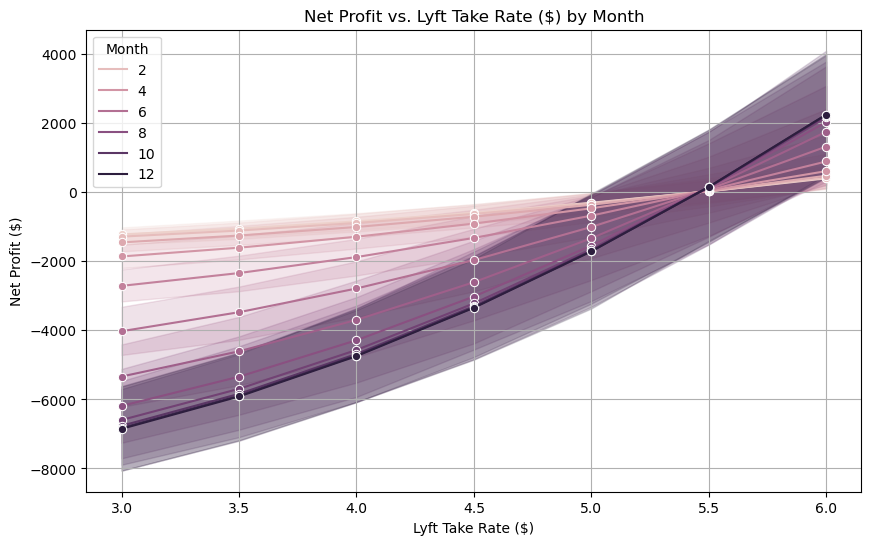

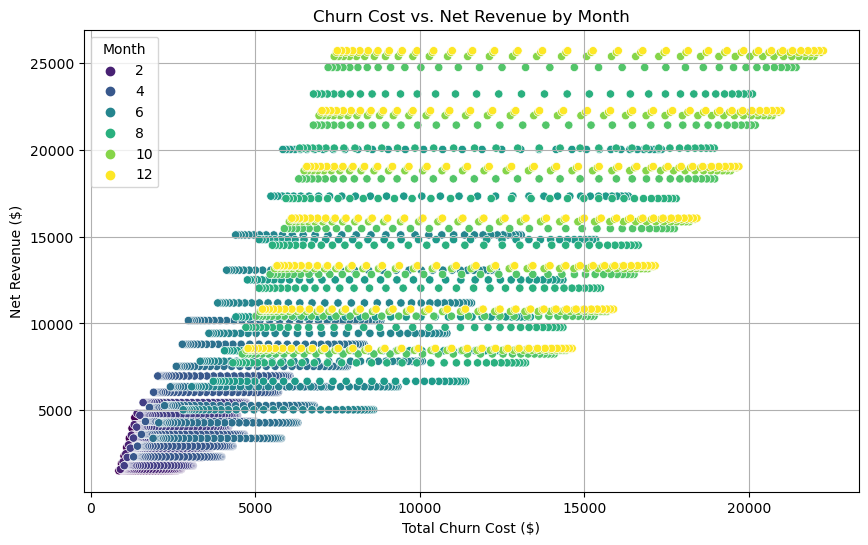

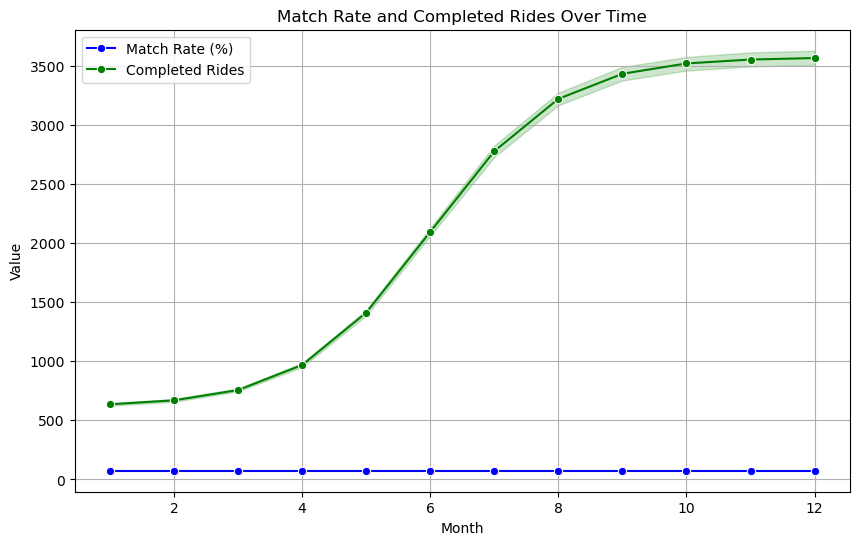

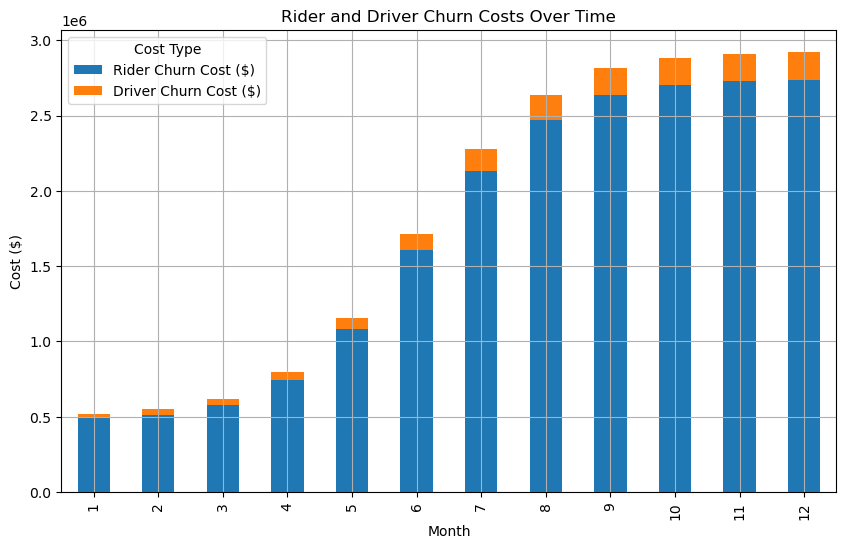

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Profitability vs. Lyft Take Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x="Lyft Take Rate ($)", y="Net Profit ($)", hue="Month", marker="o")
plt.title("Net Profit vs. Lyft Take Rate ($) by Month")
plt.xlabel("Lyft Take Rate ($)")
plt.ylabel("Net Profit ($)")
plt.legend(title="Month")
plt.grid()
plt.show()

# Churn Impact on Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="Total Churn Cost ($)", y="Net Revenue ($)", hue="Month", palette="viridis")
plt.title("Churn Cost vs. Net Revenue by Month")
plt.xlabel("Total Churn Cost ($)")
plt.ylabel("Net Revenue ($)")
plt.legend(title="Month")
plt.grid()
plt.show()

# Match Rate vs. Completed Rides
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x="Month", y="Match Rate (%)", label="Match Rate (%)", marker="o", color="blue")
sns.lineplot(data=df_final, x="Month", y="New Completed Rides", label="Completed Rides", marker="o", color="green")
plt.title("Match Rate and Completed Rides Over Time")
plt.xlabel("Month")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Cost Breakdown Over Time
df_costs = df_final.groupby("Month")[["Rider Churn Cost ($)", "Driver Churn Cost ($)"]].sum().reset_index()
df_costs.plot(
    x="Month",
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    title="Rider and Driver Churn Costs Over Time",
    ylabel="Cost ($)",
    xlabel="Month",
)
plt.legend(title="Cost Type")
plt.grid()
plt.show()


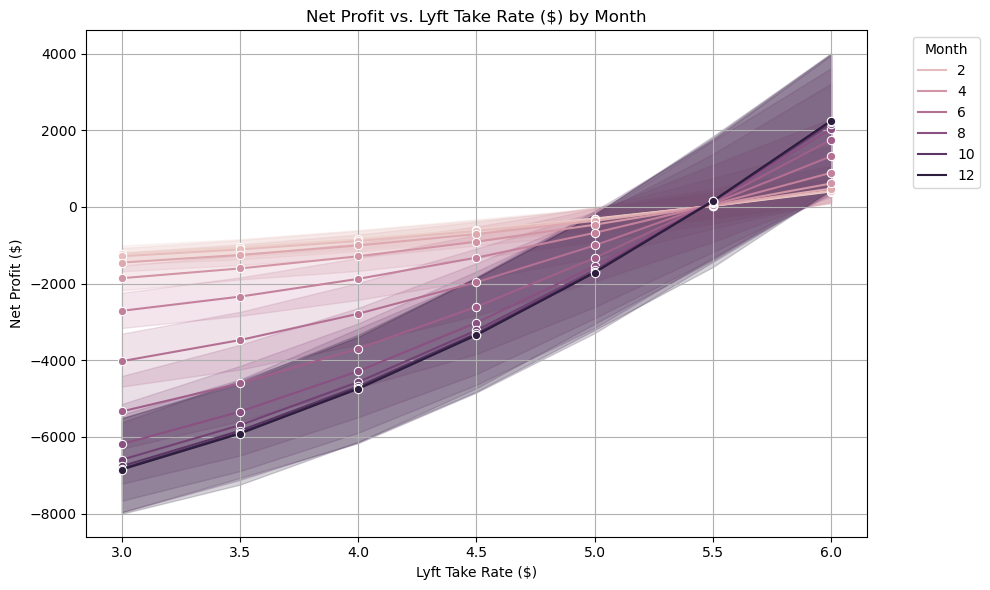

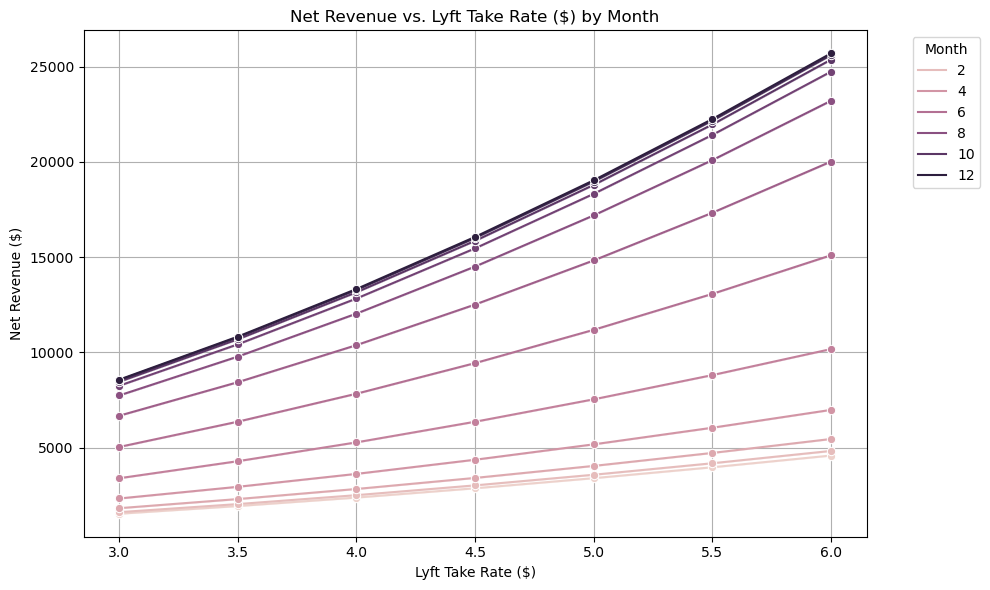

In [61]:
# Net Profit vs. Lyft Take Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x="Lyft Take Rate ($)", y="Net Profit ($)", hue="Month", marker="o")
plt.title("Net Profit vs. Lyft Take Rate ($) by Month")
plt.xlabel("Lyft Take Rate ($)")
plt.ylabel("Net Profit ($)")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Net Revenue vs. Lyft Take Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x="Lyft Take Rate ($)", y="Net Revenue ($)", hue="Month", marker="o")
plt.title("Net Revenue vs. Lyft Take Rate ($) by Month")
plt.xlabel("Lyft Take Rate ($)")
plt.ylabel("Net Revenue ($)")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

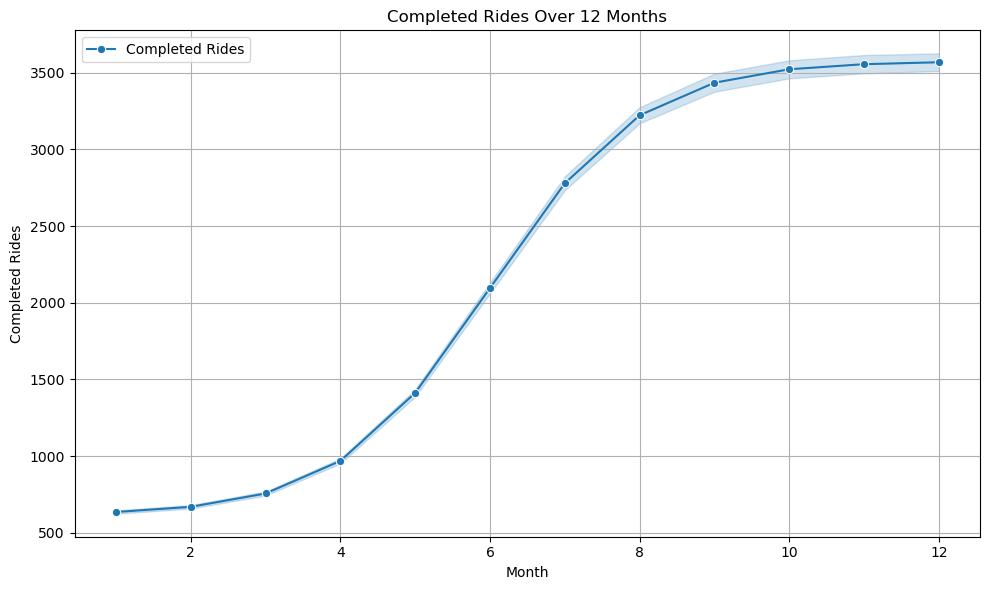

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Completed Rides Over 12 Months
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_final, x="Month", y="New Completed Rides", marker="o", label="Completed Rides")
plt.title("Completed Rides Over 12 Months")
plt.xlabel("Month")
plt.ylabel("Completed Rides")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#Now I take a break and come back to it to review my progress and improve the dataset, I realize I want to improve the reality of the match rates.

In [ ]:
### Change Match Rates for max 93% (logistic growth)

In [63]:
print(df_final["Match Rate (%)"].unique())

[60. 65. 70. 75. 80. 85. 90.]


In [66]:
# Adjust Match Rate proportionately with Lyft Take Rate
df_final["Match Rate (%)"] = 60 + 11 * (df_final["Lyft Take Rate ($)"] - 3)

# Recalculate New Completed Rides
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate dependent metrics
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Print key columns of the updated dataset
print(df_final[[
    "Lyft Take Rate ($)",
    "Match Rate (%)",
    "New Completed Rides",
    "Net Revenue ($)",
    "Net Profit ($)"
]])


      Lyft Take Rate ($)  Match Rate (%)  New Completed Rides  \
0                    3.0            60.0               508.80   
1                    3.0            60.0               508.80   
2                    3.0            60.0               508.80   
3                    3.0            60.0               508.80   
4                    3.0            60.0               508.80   
...                  ...             ...                  ...   
2851                 6.0            93.0              4424.94   
2852                 6.0            93.0              4424.94   
2853                 6.0            93.0              4424.94   
2854                 6.0            93.0              4424.94   
2855                 6.0            93.0              4424.94   

      Net Revenue ($)  Net Profit ($)  
0             1526.40    -2098.800000  
1             1526.40    -2083.368496  
2             1526.40    -2065.004399  
3             1526.40    -2043.231626  
4             1526.

In [73]:
# Parameters for match rate adjustment using logistic slope
baseline_match_rate = 60  # Match rate at $3 take rate
max_match_rate = 93  # Match rate at $6 take rate
k = 1.5  # Logistic steepness, similar to the rider churn model
t_0 = 4.5  # Midpoint of the curve (centered around $4.5 take rate)

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return baseline_match_rate + (max_match_rate - baseline_match_rate) / (1 + np.exp(-k * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds (e.g., 60% to 93%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save and display updated results
print(df_final)

df_final.to_csv("final_lyft_analysis_logistic_match_rate.csv", index=False)



      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       63.146532            848.0 

In [74]:
import numpy as np

# Parameters for Proportionate Relationship
baseline_match_rate = 60  # Match rate at $3 take rate
baseline_take_rate = 3.0  # Starting take rate
match_rate_slope = (93 - 60) / (6 - 3)  # Proportional slope for linear increase

# Parameters for Logistic Relationship
k = 1.5  # Steepness of logistic growth
t_0 = 4.5  # Midpoint of the curve

# Choose the relationship type: "proportionate", "logistic", or "combination"
relationship_type = "logistic"  # Change to "proportionate" or "combination" as needed

if relationship_type == "proportionate":
    # Proportionate relationship
    df_final["Match Rate (%)"] = (
        baseline_match_rate + match_rate_slope * (df_final["Lyft Take Rate ($)"] - baseline_take_rate)
    )

elif relationship_type == "logistic":
    # Logistic relationship
    df_final["Match Rate (%)"] = 93 / (1 + np.exp(-k * (df_final["Lyft Take Rate ($)"] - t_0)))

elif relationship_type == "combination":
    # Combination of proportionate and logistic
    proportionate_part = baseline_match_rate + match_rate_slope * (df_final["Lyft Take Rate ($)"] - baseline_take_rate)
    logistic_part = 93 / (1 + np.exp(-k * (df_final["Lyft Take Rate ($)"] - t_0)))
    df_final["Match Rate (%)"] = np.where(
        df_final["Lyft Take Rate ($)"] <= t_0, proportionate_part, logistic_part
    )

# Ensure Match Rate remains within bounds
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Recalculate dependent metrics
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save the updated dataset
df_final.to_csv("final_lyft_analysis_updated_match_rate.csv", index=False)

# Display key columns for validation
print(df_final)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000         60.0000            848.0 

In [75]:
# Parameters for match rate adjustment using logistic slope
baseline_match_rate = 60  # Match rate at $3 take rate
max_match_rate = 93  # Match rate at $6 take rate
k = 1.5  # Logistic steepness, similar to the rider churn model
t_0 = 4.5  # Midpoint of the curve (centered around $4.5 take rate)

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return baseline_match_rate + (max_match_rate - baseline_match_rate) / (1 + np.exp(-k * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds (e.g., 60% to 93%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save and display updated results
print(df_final)

df_final.to_csv("final_lyft_analysis_logistic_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       63.146532            848.0 

In [76]:
# Parameters for match rate adjustment using logistic slope
baseline_match_rate = 60  # Match rate at $3 take rate
max_match_rate = 93  # Match rate at $6 take rate
k = 2.5  # Adjusted steepness for the logistic curve
t_0 = 4.5  # Midpoint of the curve (centered around $4.5 take rate)

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return baseline_match_rate + (max_match_rate - baseline_match_rate) / (1 + np.exp(-k * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds (e.g., 60% to 93%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Print key rows to verify the match rate range
print(df_final)

# Save the full dataset for further review
df_final.to_csv("final_lyft_analysis_fixed_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.758253            848.0 

In [77]:
# Parameters for match rate adjustment using logistic slope
baseline_match_rate = 60  # Match rate at $3 take rate
max_match_rate = 93  # Match rate at $6 take rate
k = 3.0  # Steepness for a sharper curve
t_0 = 4.5  # Midpoint of the curve (centered around $4.5 take rate)

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return baseline_match_rate + (max_match_rate - baseline_match_rate) / (1 + np.exp(-k * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds (e.g., 60% to 93%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Print key rows to verify the match rate range
print(df_final)

# Save the updated dataset for further review
df_final.to_csv("final_lyft_analysis_precise_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.362569            848.0 

In [79]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Match Rate (%)", "Lyft Take Rate ($)"]])


      Match Rate (%)  Lyft Take Rate ($)
0          60.362569                 3.0
1          60.362569                 3.0
2          60.362569                 3.0
3          60.362569                 3.0
4          60.362569                 3.0
5          60.362569                 3.0
6          60.362569                 3.0
7          60.362569                 3.0
8          60.362569                 3.0
9          60.362569                 3.0
10         60.362569                 3.0
11         60.362569                 3.0
12         60.362569                 3.0
13         60.362569                 3.0
14         60.362569                 3.0
15         60.362569                 3.0
16         60.362569                 3.0
17         60.362569                 3.0
18         60.362569                 3.0
19         60.362569                 3.0
20         60.362569                 3.0
21         60.362569                 3.0
22         60.362569                 3.0
23         60.36

In [80]:
# Fine-tuned parameters for match rate adjustment
baseline_match_rate = 60  # Match rate at $3 take rate
max_match_rate = 93  # Match rate at $6 take rate
k = 3.2  # Slightly sharper steepness
t_0 = 4.5  # Midpoint of the curve (centered around $4.5 take rate)

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return baseline_match_rate + (max_match_rate - baseline_match_rate) / (1 + np.exp(-k * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds (e.g., 60% to 93%)
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Print key rows to verify the match rate range
print(df_final)

# Save the updated dataset for further review
df_final.to_csv("final_lyft_analysis_finetuned_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.269365            848.0 

In [81]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Match Rate (%)", "Lyft Take Rate ($)"]])


      Match Rate (%)  Lyft Take Rate ($)
0          60.269365                 3.0
1          60.269365                 3.0
2          60.269365                 3.0
3          60.269365                 3.0
4          60.269365                 3.0
5          60.269365                 3.0
6          60.269365                 3.0
7          60.269365                 3.0
8          60.269365                 3.0
9          60.269365                 3.0
10         60.269365                 3.0
11         60.269365                 3.0
12         60.269365                 3.0
13         60.269365                 3.0
14         60.269365                 3.0
15         60.269365                 3.0
16         60.269365                 3.0
17         60.269365                 3.0
18         60.269365                 3.0
19         60.269365                 3.0
20         60.269365                 3.0
21         60.269365                 3.0
22         60.269365                 3.0
23         60.26

In [83]:
import scipy.optimize as opt

# Solve for k numerically
def solve_k():
    def logistic_diff(k):
        # Difference between actual and expected match rates at $3 and $6
        low = 60 + (93 - 60) / (1 + np.exp(-k * (3 - 4.5))) - 60
        high = 60 + (93 - 60) / (1 + np.exp(-k * (6 - 4.5))) - 93
        return low**2 + high**2  # Minimize squared error
    result = opt.minimize(logistic_diff, x0=2)  # Initial guess for k
    return result.x[0]

k_precise = solve_k()
t_0 = 4.5  # Midpoint of the curve

# Logistic function for match rate
def logistic_match_rate(take_rate):
    return 60 + (93 - 60) / (1 + np.exp(-k_precise * (take_rate - t_0)))

# Apply the logistic function to calculate Match Rate
df_final["Match Rate (%)"] = logistic_match_rate(df_final["Lyft Take Rate ($)"])

# Ensure match rates remain within bounds
df_final["Match Rate (%)"] = df_final["Match Rate (%)"].clip(lower=60, upper=93)

# Adjust completed rides using the dynamic match rate
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Print key rows to verify the match rate range
print(df_final)

# Save the updated dataset for further review
df_final.to_csv("final_lyft_analysis_precise_logistic_match_rate.csv", index=False)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

#After many attempts, I acheive something close to a realistic logistical regression that hits the min and max provided values.

In [85]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Match Rate (%)", "Completed Rides", "Lyft Take Rate ($)"]])


      Match Rate (%)  Completed Rides  Lyft Take Rate ($)
0          60.001003            848.0                 3.0
1          60.001003            848.0                 3.0
2          60.001003            848.0                 3.0
3          60.001003            848.0                 3.0
4          60.001003            848.0                 3.0
5          60.001003            848.0                 3.0
6          60.001003            848.0                 3.0
7          60.001003            848.0                 3.0
8          60.001003            848.0                 3.0
9          60.001003            848.0                 3.0
10         60.001003            848.0                 3.0
11         60.001003            848.0                 3.0
12         60.001003            848.0                 3.0
13         60.001003            848.0                 3.0
14         60.001003            848.0                 3.0
15         60.001003            848.0                 3.0
16         60.

In [86]:
# Adjust completed rides using the match rate
df_final["Adjusted Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit with adjusted rides
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["Adjusted Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["Adjusted Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["Adjusted Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["Adjusted Completed Rides"] * 2)  # Operational cost
)

# Save the updated dataset for further review
df_final.to_csv("final_lyft_analysis_adjusted_rides.csv", index=False)

# Print a few rows to verify
print(df_final)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

In [87]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Match Rate (%)", "Completed Rides", "Lyft Take Rate ($)"]])

      Match Rate (%)  Completed Rides  Lyft Take Rate ($)
0          60.001003            848.0                 3.0
1          60.001003            848.0                 3.0
2          60.001003            848.0                 3.0
3          60.001003            848.0                 3.0
4          60.001003            848.0                 3.0
5          60.001003            848.0                 3.0
6          60.001003            848.0                 3.0
7          60.001003            848.0                 3.0
8          60.001003            848.0                 3.0
9          60.001003            848.0                 3.0
10         60.001003            848.0                 3.0
11         60.001003            848.0                 3.0
12         60.001003            848.0                 3.0
13         60.001003            848.0                 3.0
14         60.001003            848.0                 3.0
15         60.001003            848.0                 3.0
16         60.

#Now I realize the completed rides column is not connected with the match rate, so I create a new column (as you can see I do it twice with New and Adjusted, this was an error on my end.)

In [88]:
# Adjust completed rides using the match rate
df_final["Adjusted Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate churn costs, net revenue, and net profit with adjusted rides
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["Adjusted Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["Adjusted Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["Adjusted Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["Adjusted Completed Rides"] * 2)  # Operational cost
)

# Save the updated dataset
df_final.to_csv("final_lyft_analysis_adjusted_rides_corrected.csv", index=False)

# Print a few rows to verify
print(df_final)


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

In [89]:
# Temporarily display all rows for Rider Churn (%) and Driver Churn (%)
with pd.option_context('display.max_rows', None):  # Show all rows
    print(df_final[["Match Rate (%)", "Completed Rides", "Lyft Take Rate ($)"]])

      Match Rate (%)  Completed Rides  Lyft Take Rate ($)
0          60.001003            848.0                 3.0
1          60.001003            848.0                 3.0
2          60.001003            848.0                 3.0
3          60.001003            848.0                 3.0
4          60.001003            848.0                 3.0
5          60.001003            848.0                 3.0
6          60.001003            848.0                 3.0
7          60.001003            848.0                 3.0
8          60.001003            848.0                 3.0
9          60.001003            848.0                 3.0
10         60.001003            848.0                 3.0
11         60.001003            848.0                 3.0
12         60.001003            848.0                 3.0
13         60.001003            848.0                 3.0
14         60.001003            848.0                 3.0
15         60.001003            848.0                 3.0
16         60.

In [94]:
# Adjust completed rides using the match rate
df_final["Adjusted Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate all metrics based on the adjusted completed rides
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["Adjusted Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["Adjusted Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["Adjusted Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["Adjusted Completed Rides"] * 2)  # Operational cost
)

# Save the updated dataset for review
df_final.to_csv("final_lyft_analysis_adjusted_rides_corrected.csv", index=False)

print(df_final)

# Display the updated columns for verification
with pd.option_context('display.max_rows', None):  # Show all rows for verification
    print(df_final[["Match Rate (%)", "Completed Rides", "Adjusted Completed Rides", "New Completed Rides", "Lyft Take Rate ($)"]])


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

In [92]:
print(df_final)

      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

In [95]:
# Adjust completed rides using the match rate and update "New Completed Rides"
df_final["New Completed Rides"] = (
    df_final["Completed Rides"] * (df_final["Match Rate (%)"] / 100)
)

# Recalculate all metrics based on the updated "New Completed Rides"
df_final["Rider Churn Cost ($)"] = (
    (df_final["Rider Churn (%)"] / 100) * 15 * df_final["New Completed Rides"]
)
df_final["Driver Churn Cost ($)"] = (
    (df_final["Driver Churn (%)"] / 100) * 500 * df_final["New Completed Rides"] / 100
)
df_final["Total Churn Cost ($)"] = (
    df_final["Rider Churn Cost ($)"] + df_final["Driver Churn Cost ($)"]
)
df_final["Net Revenue ($)"] = (
    df_final["New Completed Rides"] * df_final["Lyft Take Rate ($)"]
)
df_final["Net Profit ($)"] = (
    df_final["Net Revenue ($)"]
    - df_final["Total Churn Cost ($)"]
    - (df_final["New Completed Rides"] * 2)  # Operational cost
)

# Save the updated dataset for review
df_final.to_csv("final_lyft_analysis_corrected.csv", index=False)

print(df_final)

# Display the updated columns for verification
with pd.option_context('display.max_rows', None):  # Show all rows for verification
    print(df_final[["Match Rate (%)", "Completed Rides", "New Completed Rides", "Lyft Take Rate ($)"]])


      Month  Lyft Take Rate ($)  Driver Payout ($)  Driver Churn (%)  \
0         1                 3.0               22.0               3.5   
1         1                 3.0               22.0               3.5   
2         1                 3.0               22.0               3.5   
3         1                 3.0               22.0               3.5   
4         1                 3.0               22.0               3.5   
...     ...                 ...                ...               ...   
2851     12                 6.0               19.0               5.0   
2852     12                 6.0               19.0               5.0   
2853     12                 6.0               19.0               5.0   
2854     12                 6.0               19.0               5.0   
2855     12                 6.0               19.0               5.0   

      Rider Churn (%)  Match Rate (%)  Completed Rides  Rider Churn Cost ($)  \
0           33.000000       60.001003            848.0 

#now I think I have it, and test it out with a visual to realize its needs some more improvement.

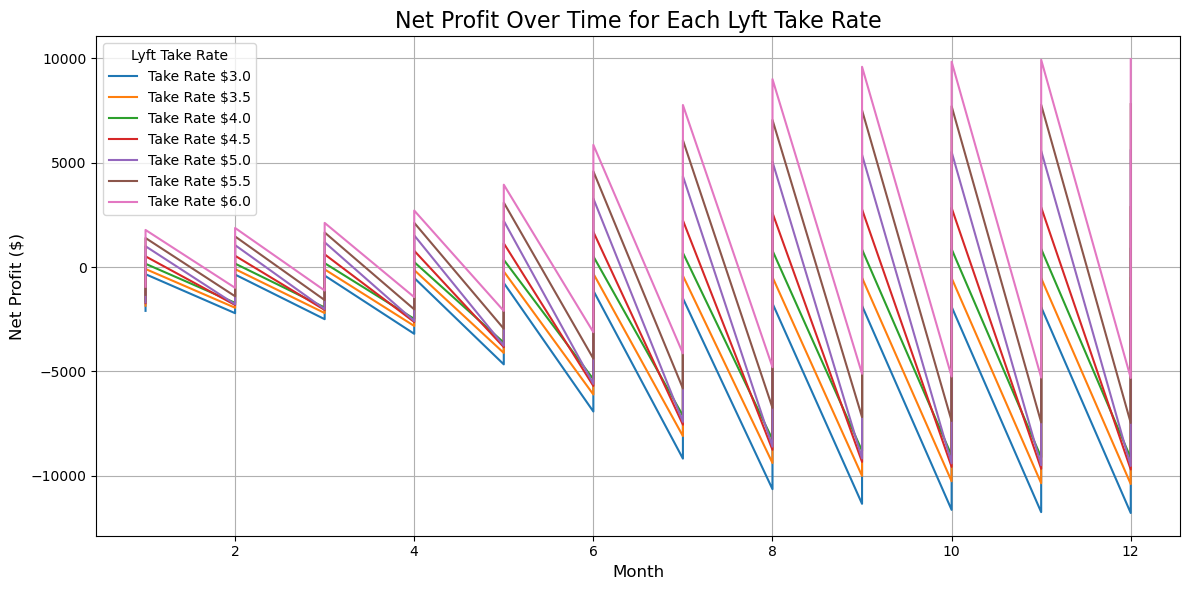

In [96]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Net Profit for each Lyft Take Rate
for take_rate in df_final["Lyft Take Rate ($)"].unique():
    subset = df_final[df_final["Lyft Take Rate ($)"] == take_rate]
    plt.plot(subset["Month"], subset["Net Profit ($)"], label=f'Take Rate ${take_rate:.1f}')

# Add labels, title, and legend
plt.title("Net Profit Over Time for Each Lyft Take Rate", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.legend(title="Lyft Take Rate", fontsize=10)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


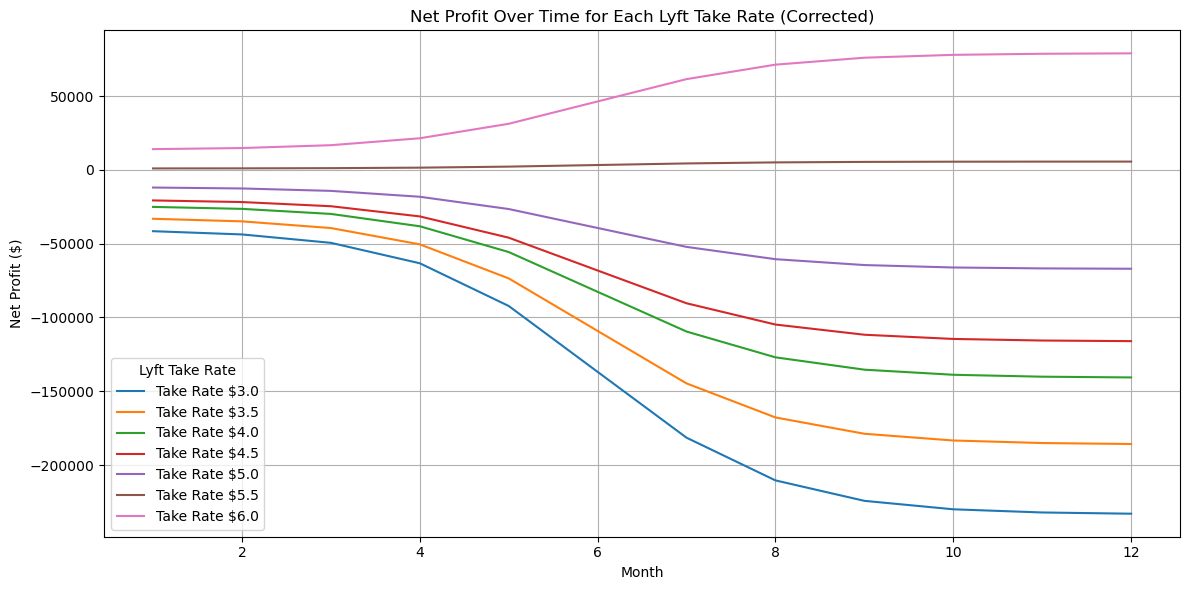

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_final is your DataFrame with the necessary columns
# Group the data by Month and Lyft Take Rate ($), and recalculate Net Profit
df_grouped = df_final.groupby(["Month", "Lyft Take Rate ($)"], as_index=False).agg({
    "Net Profit ($)": "sum",  # Sum Net Profit for each combination
    "New Completed Rides": "sum",  # Optional: Keep track of total rides if necessary
})

# Create a pivot table for easier plotting
pivot_df = df_grouped.pivot(index="Month", columns="Lyft Take Rate ($)", values="Net Profit ($)")

# Plotting the data
plt.figure(figsize=(12, 6))
for take_rate in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[take_rate], label=f"Take Rate ${take_rate:.1f}")

plt.title("Net Profit Over Time for Each Lyft Take Rate (Corrected)")
plt.xlabel("Month")
plt.ylabel("Net Profit ($)")
plt.legend(title="Lyft Take Rate")
plt.grid()
plt.tight_layout()
plt.show()


#beatiful isn't it? 

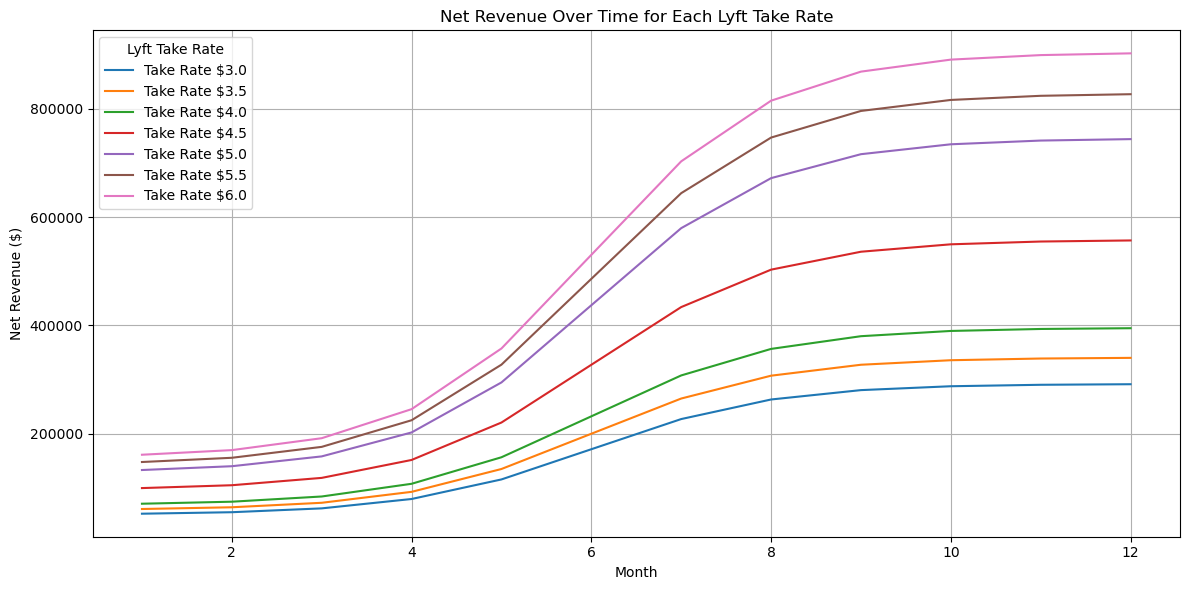

In [98]:
# Group the data by Month and Lyft Take Rate ($), and recalculate Net Revenue
df_grouped_revenue = df_final.groupby(["Month", "Lyft Take Rate ($)"], as_index=False).agg({
    "Net Revenue ($)": "sum",  # Sum Net Revenue for each combination
    "New Completed Rides": "sum",  # Optional: Keep track of total rides if necessary
})

# Create a pivot table for easier plotting
pivot_df_revenue = df_grouped_revenue.pivot(index="Month", columns="Lyft Take Rate ($)", values="Net Revenue ($)")

# Plotting the data
plt.figure(figsize=(12, 6))
for take_rate in pivot_df_revenue.columns:
    plt.plot(pivot_df_revenue.index, pivot_df_revenue[take_rate], label=f"Take Rate ${take_rate:.1f}")

plt.title("Net Revenue Over Time for Each Lyft Take Rate")
plt.xlabel("Month")
plt.ylabel("Net Revenue ($)")
plt.legend(title="Lyft Take Rate")
plt.grid()
plt.tight_layout()
plt.show()


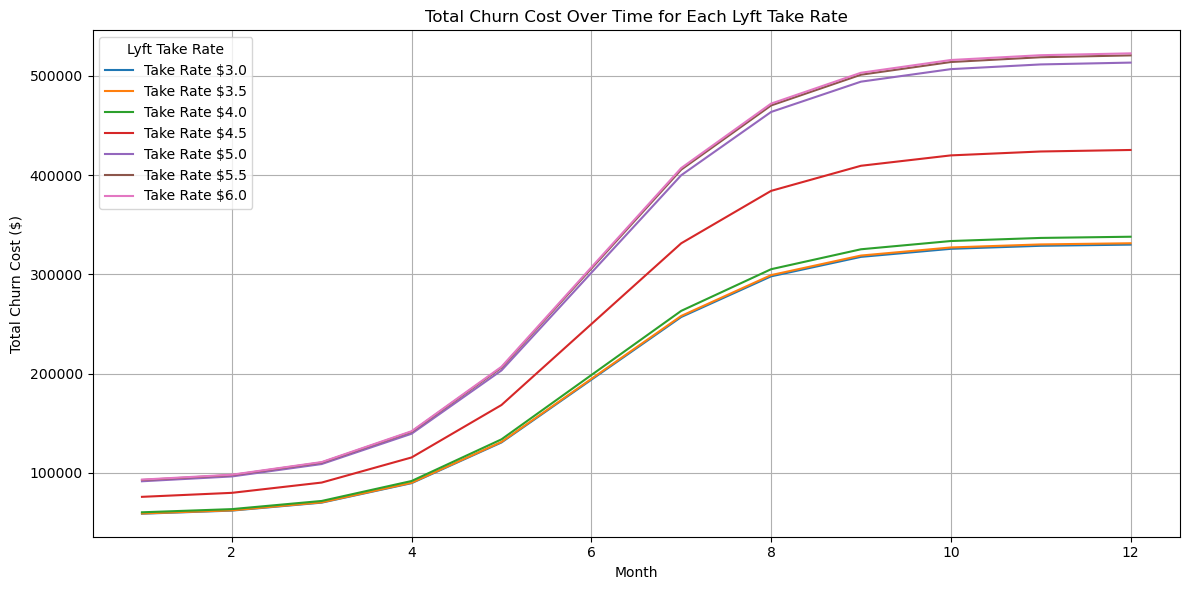

In [99]:
import matplotlib.pyplot as plt

# Group the data by Month and Lyft Take Rate ($), and aggregate Churn Costs
df_grouped_churn = df_final.groupby(["Month", "Lyft Take Rate ($)"], as_index=False).agg({
    "Total Churn Cost ($)": "sum",  # Sum churn cost for each combination
})

# Create a pivot table for easier plotting
pivot_df_churn = df_grouped_churn.pivot(index="Month", columns="Lyft Take Rate ($)", values="Total Churn Cost ($)")

# Plotting the data
plt.figure(figsize=(12, 6))
for take_rate in pivot_df_churn.columns:
    plt.plot(pivot_df_churn.index, pivot_df_churn[take_rate], label=f"Take Rate ${take_rate:.1f}")

plt.title("Total Churn Cost Over Time for Each Lyft Take Rate")
plt.xlabel("Month")
plt.ylabel("Total Churn Cost ($)")
plt.legend(title="Lyft Take Rate")
plt.grid()
plt.tight_layout()
plt.show()


#I debately could have stopped here and confirmed it all made the most sense. But then I wanted to go deeper, by making predictions using a model. A different way of looking at the scenario.

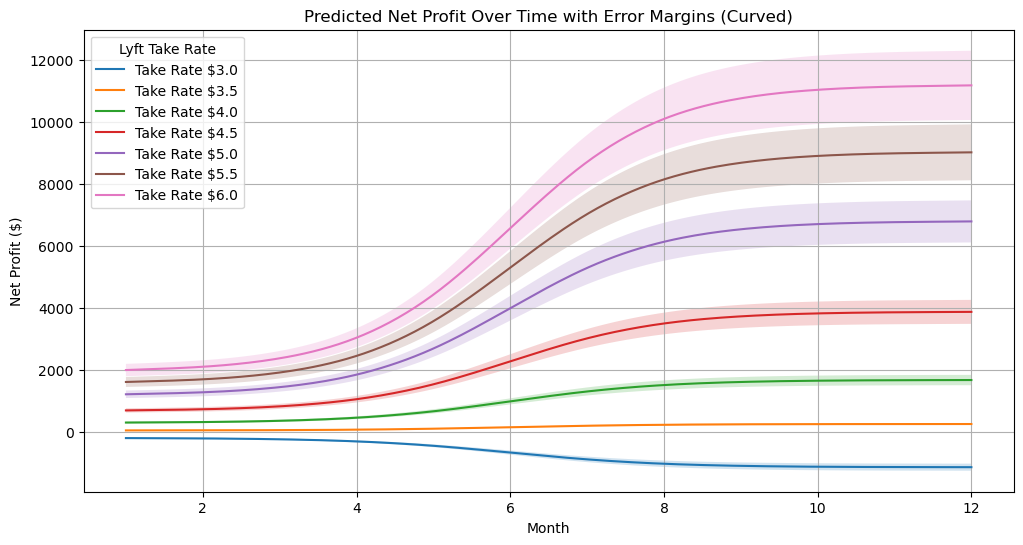

In [107]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

# Verify if 'Net Profit' exists; if not, create it
if 'Net Profit' not in df_final.columns:
    df_final['Net Profit ($)'] = df_final['Net Revenue ($)'] - df_final['Total Churn Cost ($)']

# Define the error percentage (e.g., 10% variability)
error_percentage = 0.10

# Create a prediction DataFrame for each Lyft take rate
predictions = []
for take_rate in df_final['Lyft Take Rate ($)'].unique():
    # Filter data for the current take rate
    data = df_final[df_final['Lyft Take Rate ($)'] == take_rate]
    
    # Aggregate duplicate months by taking the mean of 'Net Profit'
    data = data.groupby('Month', as_index=False).agg({'Net Profit ($)': 'mean'})
    
    months = data['Month']
    net_profit = data['Net Profit ($)']
    
    # Use spline interpolation for smooth curves
    spline = make_interp_spline(months, net_profit, k=3)  # k=3 for cubic spline
    months_smooth = np.linspace(months.min(), months.max(), 200)  # More points for smooth curve
    predicted_profit = spline(months_smooth)
    
    # Add error margins
    lower_bound = predicted_profit * (1 - error_percentage)
    upper_bound = predicted_profit * (1 + error_percentage)
    
    predictions.append(pd.DataFrame({
        'Month': months_smooth,
        'Lyft Take Rate ($)': take_rate,
        'Predicted Profit': predicted_profit,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }))

# Concatenate all predictions into one DataFrame
predictions_df = pd.concat(predictions, ignore_index=True)

# Plot predictions with error margins
plt.figure(figsize=(12, 6))

for take_rate in predictions_df['Lyft Take Rate ($)'].unique():
    data = predictions_df[predictions_df['Lyft Take Rate ($)'] == take_rate]
    plt.plot(data['Month'], data['Predicted Profit'], label=f'Take Rate ${take_rate:.1f}')
    plt.fill_between(data['Month'], data['Lower Bound'], data['Upper Bound'], alpha=0.2)

plt.title('Predicted Net Profit Over Time with Error Margins (Curved)')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Lyft Take Rate', loc='best')
plt.grid(True)
plt.show()




#I love this graph. 

#The next bit of code is me playing with the dataset to see what I can find, its a bit messy, but I kept it to show my thought process. 

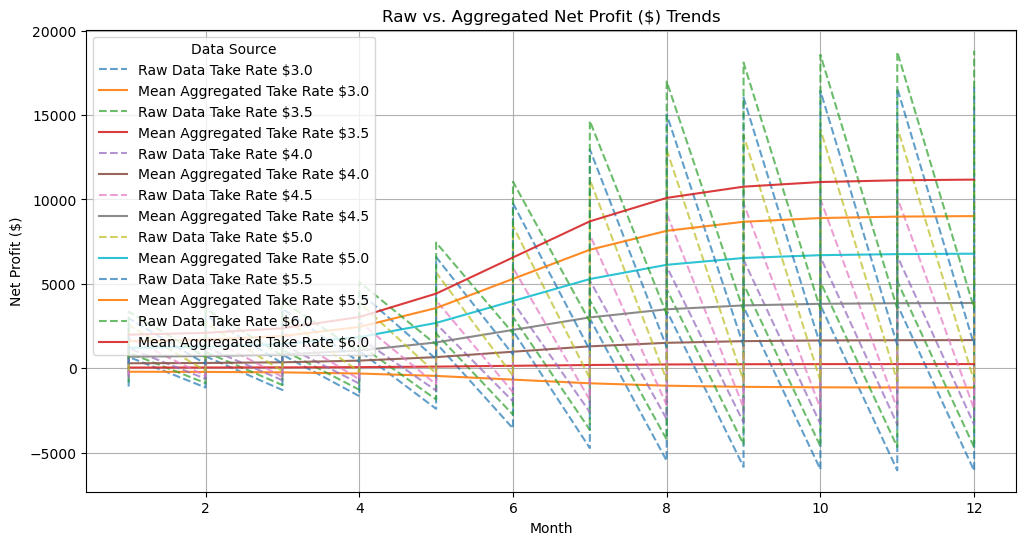

ModuleNotFoundError: No module named 'ace_tools'

In [108]:
# Step 1: Analyze raw net profit values
# Re-extract the raw Net Profit ($) from the dataset
raw_data = df_final[['Month', 'Lyft Take Rate ($)', 'Net Profit ($)']]

# Aggregate duplicate months using different methods for comparison
# Option 1: Sum duplicate months
sum_aggregated = raw_data.groupby(['Month', 'Lyft Take Rate ($)'], as_index=False).sum()

# Option 2: Mean duplicate months
mean_aggregated = raw_data.groupby(['Month', 'Lyft Take Rate ($)'], as_index=False).mean()

# Check for differences between sum and mean aggregation
comparison = sum_aggregated.merge(mean_aggregated, on=['Month', 'Lyft Take Rate ($)'], suffixes=('_sum', '_mean'))

# Step 2: Plot raw data trends and aggregated trends for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for take_rate in raw_data['Lyft Take Rate ($)'].unique():
    # Raw data
    raw_subset = raw_data[raw_data['Lyft Take Rate ($)'] == take_rate]
    plt.plot(raw_subset['Month'], raw_subset['Net Profit ($)'], label=f'Raw Data Take Rate ${take_rate:.1f}', linestyle='--', alpha=0.7)
    
    # Aggregated (mean)
    mean_subset = mean_aggregated[mean_aggregated['Lyft Take Rate ($)'] == take_rate]
    plt.plot(mean_subset['Month'], mean_subset['Net Profit ($)'], label=f'Mean Aggregated Take Rate ${take_rate:.1f}', alpha=0.9)

plt.title('Raw vs. Aggregated Net Profit ($) Trends')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Data Source', loc='best')
plt.grid(True)
plt.show()

# Display comparison for sum vs mean aggregated trends
import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison of Sum vs Mean Aggregated Net Profit", dataframe=comparison)


In [109]:
import ace_tools as tools

# Display comparison for sum vs mean aggregated trends
tools.display_dataframe_to_user(name="Comparison of Sum vs Mean Aggregated Net Profit Trends", dataframe=comparison)


ModuleNotFoundError: No module named 'ace_tools'

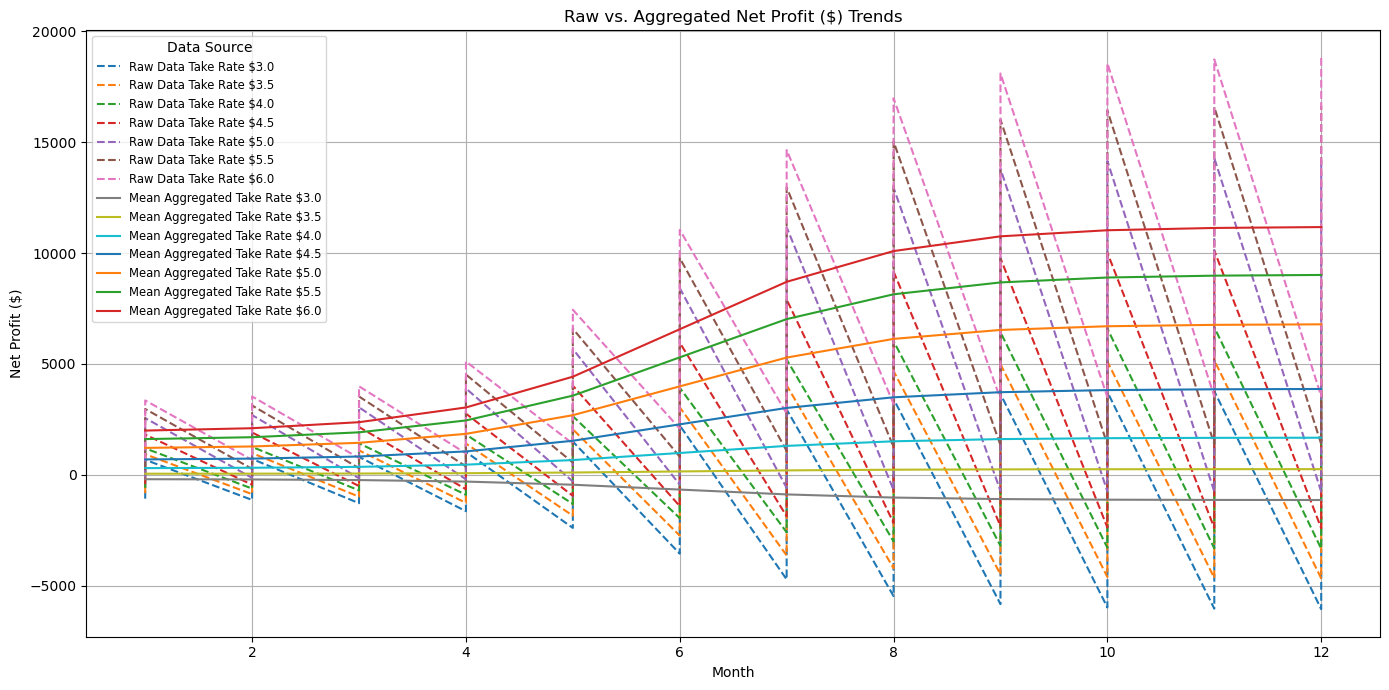

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df_final is your main DataFrame
# Ensure 'Net Profit ($)' exists in the DataFrame
if 'Net Profit ($)' not in df_final.columns:
    df_final['Net Profit ($)'] = df_final['Net Revenue ($)'] - df_final['Total Churn Cost ($)']

# Create raw and aggregated DataFrames
raw_data = df_final[['Month', 'Lyft Take Rate ($)', 'Net Profit ($)']]
mean_aggregated_data = raw_data.groupby(['Month', 'Lyft Take Rate ($)'], as_index=False).mean()

# Plot raw vs. aggregated trends
plt.figure(figsize=(14, 7))

# Plot raw data
for take_rate in raw_data['Lyft Take Rate ($)'].unique():
    data = raw_data[raw_data['Lyft Take Rate ($)'] == take_rate]
    plt.plot(data['Month'], data['Net Profit ($)'], linestyle='dashed', label=f'Raw Data Take Rate ${take_rate:.1f}')

# Plot aggregated data
for take_rate in mean_aggregated_data['Lyft Take Rate ($)'].unique():
    data = mean_aggregated_data[mean_aggregated_data['Lyft Take Rate ($)'] == take_rate]
    plt.plot(data['Month'], data['Net Profit ($)'], label=f'Mean Aggregated Take Rate ${take_rate:.1f}')

# Add labels, title, and legend
plt.title("Raw vs. Aggregated Net Profit ($) Trends")
plt.xlabel("Month")
plt.ylabel("Net Profit ($)")
plt.legend(title="Data Source", loc="best", fontsize='small')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save to CSV if needed for further analysis
comparison = mean_aggregated_data.copy()  # If you'd like to save this data
comparison.to_csv("comparison_net_profit.csv", index=False)


In [111]:
# Check for duplicates in the dataset
duplicates = raw_data[raw_data.duplicated(subset=['Month', 'Lyft Take Rate ($)'], keep=False)]
print(duplicates)


      Month  Lyft Take Rate ($)  Net Profit ($)
0         1                 3.0    -1081.218073
1         1                 3.0    -1065.786311
2         1                 3.0    -1047.421907
3         1                 3.0    -1025.648770
4         1                 3.0     -999.947862
...     ...                 ...             ...
2851     12                 6.0    18099.019554
2852     12                 6.0    18322.529479
2853     12                 6.0    18511.881235
2854     12                 6.0    18671.588688
2855     12                 6.0    18805.792193

[2856 rows x 3 columns]


In [112]:
# Check for outliers in Net Profit ($)
outliers = raw_data[raw_data['Net Profit ($)'] > raw_data['Net Profit ($)'].quantile(0.95)]
print(outliers)


      Month  Lyft Take Rate ($)  Net Profit ($)
1659      7                 6.0    13654.281550
1660      7                 6.0    13892.873176
1661      7                 6.0    14097.302746
1662      7                 6.0    14271.394335
1663      7                 6.0    14418.880172
...     ...                 ...             ...
2851     12                 6.0    18099.019554
2852     12                 6.0    18322.529479
2853     12                 6.0    18511.881235
2854     12                 6.0    18671.588688
2855     12                 6.0    18805.792193

[143 rows x 3 columns]


             Month  Lyft Take Rate ($)  Net Profit ($)
count  2856.000000         2856.000000     2856.000000
mean      6.500000            4.500000     2808.032170
std       3.452657            1.000175     4690.285548
min       1.000000            3.000000    -6066.551404
25%       3.750000            3.500000     -139.830627
50%       6.500000            4.500000     1628.073511
75%       9.250000            5.500000     4504.527869
max      12.000000            6.000000    18805.792193


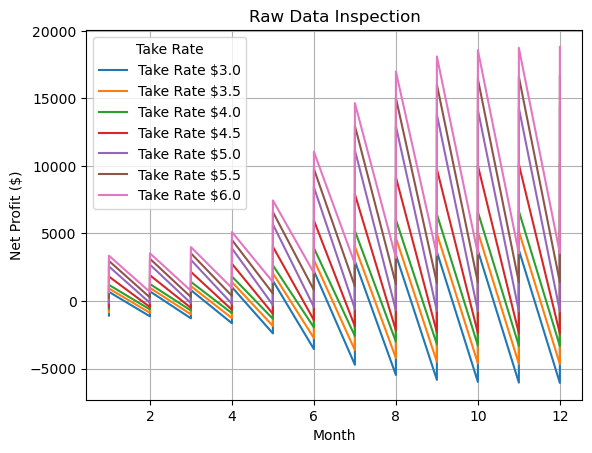

In [113]:
# Summarize raw data
print(raw_data.describe())

# Plot raw data for each take rate separately for better clarity
for take_rate in raw_data['Lyft Take Rate ($)'].unique():
    subset = raw_data[raw_data['Lyft Take Rate ($)'] == take_rate]
    plt.plot(subset['Month'], subset['Net Profit ($)'], label=f'Take Rate ${take_rate:.1f}')
plt.legend(title="Take Rate")
plt.title("Raw Data Inspection")
plt.xlabel("Month")
plt.ylabel("Net Profit ($)")
plt.grid(True)
plt.show()



In [114]:
highest_peaks = raw_data[raw_data['Net Profit ($)'] == raw_data['Net Profit ($)'].max()]
lowest_troughs = raw_data[raw_data['Net Profit ($)'] == raw_data['Net Profit ($)'].min()]
print("Highest Peaks:\n", highest_peaks)
print("Lowest Troughs:\n", lowest_troughs)


Highest Peaks:
       Month  Lyft Take Rate ($)  Net Profit ($)
2855     12                 6.0    18805.792193
Lowest Troughs:
       Month  Lyft Take Rate ($)  Net Profit ($)
2618     12                 3.0    -6066.551404


/var/folders/6g/9_rtgwc16kq0vxq3xkt1ln500000gn/T/ipykernel_60223/3202295750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_cleaned['Net Profit ($)'] = raw_data_cleaned['Net Profit ($)'].clip(upper=upper_limit)


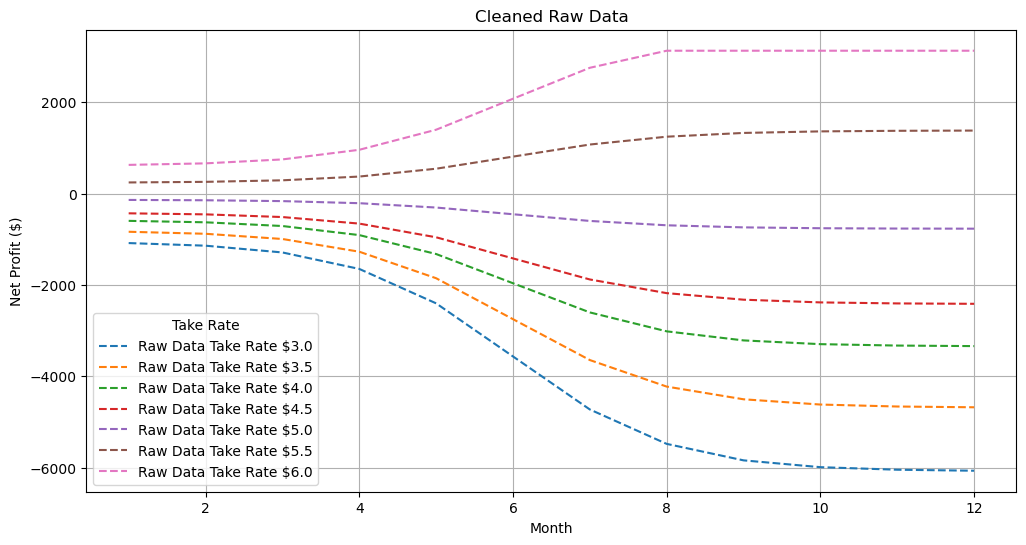

In [115]:
# Remove duplicates
raw_data_cleaned = raw_data.drop_duplicates(subset=['Month', 'Lyft Take Rate ($)'])

# Cap extreme outliers
upper_limit = raw_data_cleaned['Net Profit ($)'].quantile(0.95)
raw_data_cleaned['Net Profit ($)'] = raw_data_cleaned['Net Profit ($)'].clip(upper=upper_limit)

# Re-plot cleaned data
plt.figure(figsize=(12, 6))
for take_rate in raw_data_cleaned['Lyft Take Rate ($)'].unique():
    subset = raw_data_cleaned[raw_data_cleaned['Lyft Take Rate ($)'] == take_rate]
    plt.plot(subset['Month'], subset['Net Profit ($)'], linestyle='dashed', label=f'Raw Data Take Rate ${take_rate:.1f}')
plt.legend(title="Take Rate")
plt.title("Cleaned Raw Data")
plt.xlabel("Month")
plt.ylabel("Net Profit ($)")
plt.grid(True)
plt.show()


Error processing raw data for take rate $3.0: name 'df_cleaned' is not defined
Error processing raw data for take rate $3.5: name 'df_cleaned' is not defined
Error processing raw data for take rate $4.0: name 'df_cleaned' is not defined
Error processing raw data for take rate $4.5: name 'df_cleaned' is not defined
Error processing raw data for take rate $5.0: name 'df_cleaned' is not defined
Error processing raw data for take rate $5.5: name 'df_cleaned' is not defined
Error processing raw data for take rate $6.0: name 'df_cleaned' is not defined


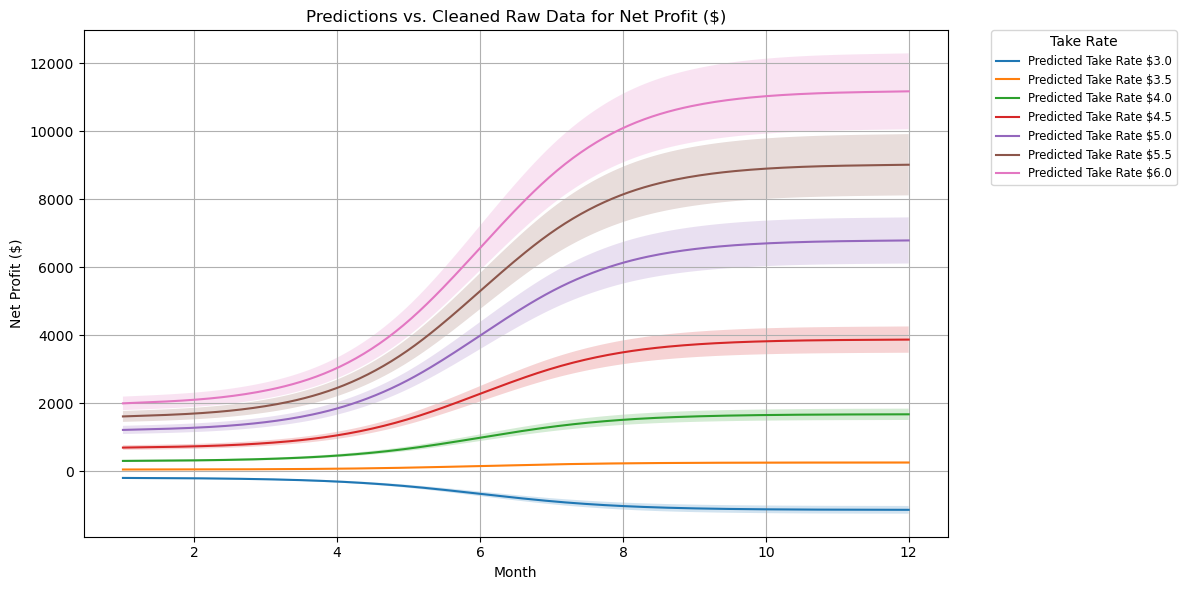

In [116]:
import matplotlib.pyplot as plt

# Plot the cleaned raw data
plt.figure(figsize=(12, 6))
for take_rate in df_final['Lyft Take Rate ($)'].unique():
    # Filter cleaned data for the current take rate
    try:
        data = df_cleaned[df_cleaned['Lyft Take Rate ($)'] == take_rate]
        plt.plot(data['Month'], data['Net Profit ($)'], linestyle='--', label=f'Raw Data Take Rate ${take_rate:.1f}')
    except Exception as e:
        print(f"Error processing raw data for take rate ${take_rate:.1f}: {e}")

# Plot the predictions
for take_rate in predictions_df['Lyft Take Rate ($)'].unique():
    try:
        data = predictions_df[predictions_df['Lyft Take Rate ($)'] == take_rate]
        plt.plot(data['Month'], data['Predicted Profit'], label=f'Predicted Take Rate ${take_rate:.1f}')
        plt.fill_between(data['Month'], data['Lower Bound'], data['Upper Bound'], alpha=0.2)
    except Exception as e:
        print(f"Error processing predictions for take rate ${take_rate:.1f}: {e}")

plt.title('Predictions vs. Cleaned Raw Data for Net Profit ($)')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Take Rate', loc='best', fontsize='small', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


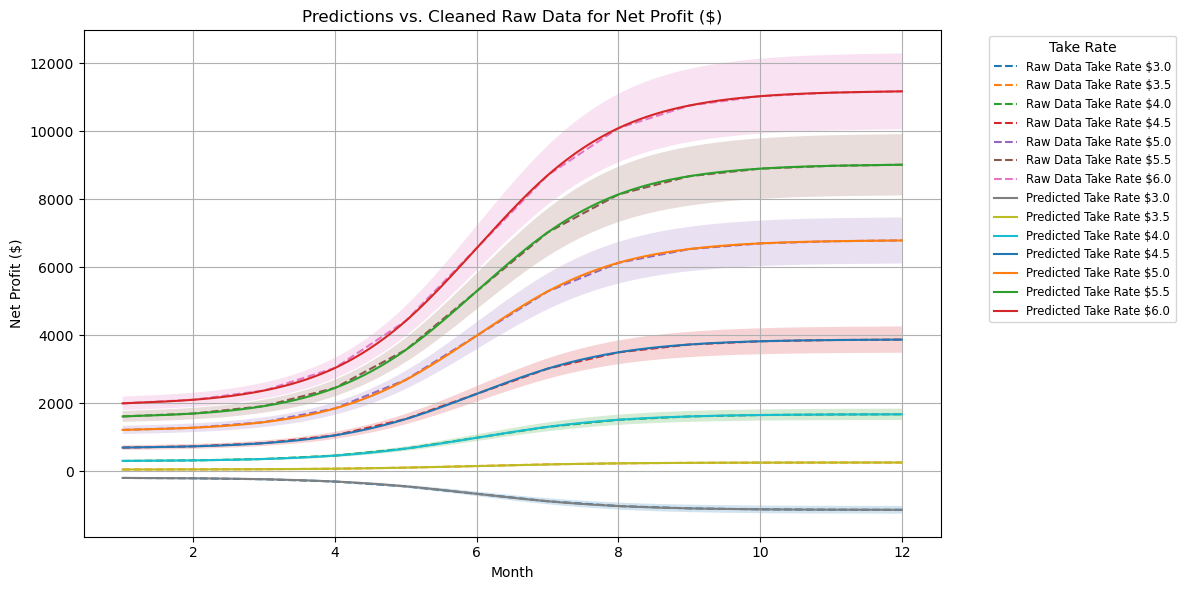

In [117]:
import matplotlib.pyplot as plt

# Define the cleaned raw data again for clarity
df_cleaned = df_final.groupby(['Month', 'Lyft Take Rate ($)'], as_index=False).agg({'Net Profit ($)': 'mean'})

# Plot the cleaned raw data
plt.figure(figsize=(12, 6))
for take_rate in df_cleaned['Lyft Take Rate ($)'].unique():
    data = df_cleaned[df_cleaned['Lyft Take Rate ($)'] == take_rate]
    plt.plot(
        data['Month'], 
        data['Net Profit ($)'], 
        linestyle='--', 
        label=f'Raw Data Take Rate ${take_rate:.1f}'
    )

# Plot the predictions
for take_rate in predictions_df['Lyft Take Rate ($)'].unique():
    data = predictions_df[predictions_df['Lyft Take Rate ($)'] == take_rate]
    plt.plot(
        data['Month'], 
        data['Predicted Profit'], 
        label=f'Predicted Take Rate ${take_rate:.1f}'
    )
    plt.fill_between(
        data['Month'], 
        data['Lower Bound'], 
        data['Upper Bound'], 
        alpha=0.2
    )

# Final plot settings
plt.title('Predictions vs. Cleaned Raw Data for Net Profit ($)')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Take Rate', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


#Another gorgeous graph. and a realization that I am sort of doing the same thing twice, cause either way its mostly made up numbers. 

#The rest of this Notebook is more exploration with mostly deadends. 

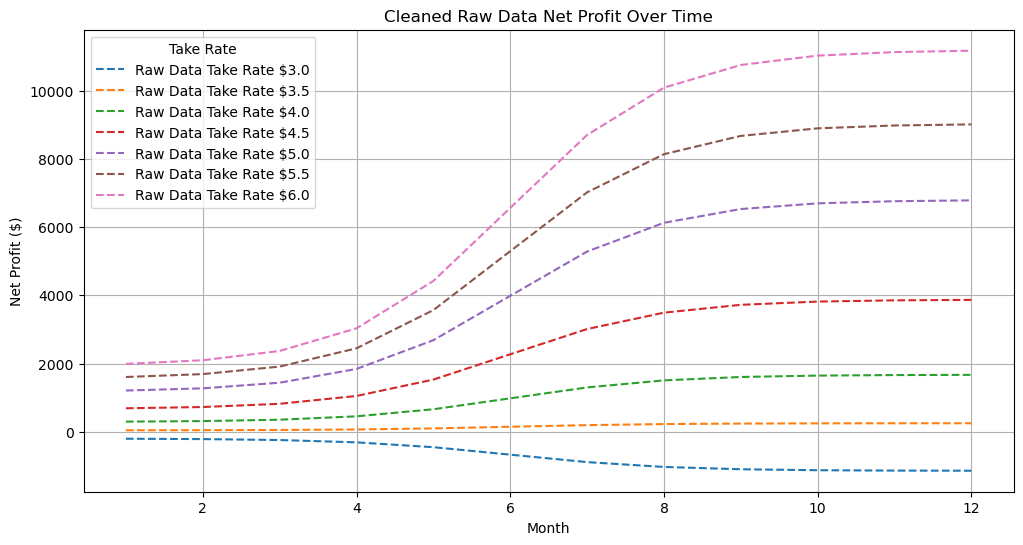

In [118]:
import matplotlib.pyplot as plt

# Plot the cleaned raw data
plt.figure(figsize=(12, 6))
for take_rate in df_cleaned['Lyft Take Rate ($)'].unique():
    # Filter cleaned data by take rate
    raw_data = df_cleaned[df_cleaned['Lyft Take Rate ($)'] == take_rate]
    plt.plot(raw_data['Month'], raw_data['Net Profit ($)'], '--', label=f'Raw Data Take Rate ${take_rate:.1f}')

plt.title('Cleaned Raw Data Net Profit Over Time')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Take Rate', loc='best')
plt.grid(True)
plt.show()


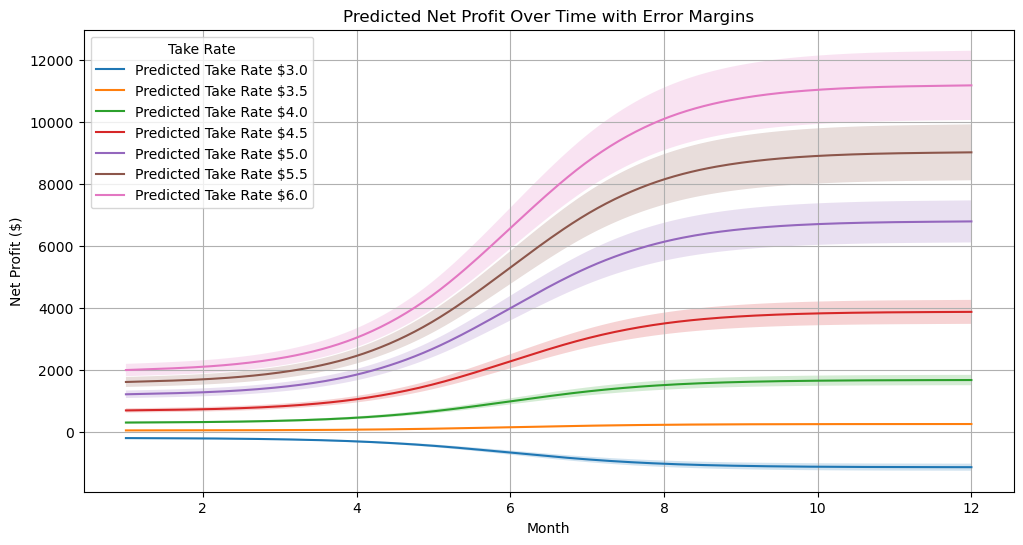

In [120]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

# Define the error percentage (e.g., 10% variability)
error_percentage = 0.10

# Create prediction DataFrame for each Lyft take rate
predictions = []
for take_rate in df_cleaned['Lyft Take Rate ($)'].unique():
    # Filter cleaned data for the current take rate
    data = df_cleaned[df_cleaned['Lyft Take Rate ($)'] == take_rate]
    
    # Aggregate duplicate months by taking the mean of 'Net Profit ($)'
    data = data.groupby('Month', as_index=False).agg({'Net Profit ($)': 'mean'})
    
    months = data['Month']
    net_profit = data['Net Profit ($)']
    
    # Use spline interpolation for smooth curves
    spline = make_interp_spline(months, net_profit, k=3)  # k=3 for cubic spline
    months_smooth = np.linspace(months.min(), months.max(), 200)  # More points for smooth curve
    predicted_profit = spline(months_smooth)
    
    # Add error margins
    lower_bound = predicted_profit * (1 - error_percentage)
    upper_bound = predicted_profit * (1 + error_percentage)
    
    predictions.append(pd.DataFrame({
        'Month': months_smooth,
        'Lyft Take Rate ($)': take_rate,
        'Predicted Profit': predicted_profit,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }))

# Concatenate all predictions into one DataFrame
predictions_df = pd.concat(predictions, ignore_index=True)

# Plot predictions with error margins
plt.figure(figsize=(12, 6))

for take_rate in predictions_df['Lyft Take Rate ($)'].unique():
    data = predictions_df[predictions_df['Lyft Take Rate ($)'] == take_rate]
    plt.plot(data['Month'], data['Predicted Profit'], label=f'Predicted Take Rate ${take_rate:.1f}')
    plt.fill_between(data['Month'], data['Lower Bound'], data['Upper Bound'], alpha=0.2)

plt.title('Predicted Net Profit Over Time with Error Margins')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.legend(title='Take Rate', loc='best')
plt.grid(True)
plt.show()



In [123]:
# Summarize raw vs. cleaned data for comparison
print("Original Data Summary:")
print(df.describe())
print("\nCleaned Data Summary:")
print(df_cleaned.describe())
print("\nRaw Data Summary:")
print(df_final.describe())

Original Data Summary:
       Match Rate (%)  Predicted Rider Churn (%)
count       34.000000                  34.000000
mean        76.500000                  21.500000
std          9.958246                   8.355530
min         60.000000                  10.000000
25%         68.250000                  13.246165
50%         76.500000                  21.500000
75%         84.750000                  29.753835
max         93.000000                  33.000000

Cleaned Data Summary:
           Month  Lyft Take Rate ($)  Net Profit ($)
count  84.000000           84.000000       84.000000
mean    6.500000            4.500000     2808.032170
std     3.472786            1.006006     3411.323631
min     1.000000            3.000000    -1141.939088
25%     3.750000            3.500000      245.188010
50%     6.500000            4.500000     1626.918557
75%     9.250000            5.500000     4094.722292
max    12.000000            6.000000    11172.853009

Raw Data Summary:
             Mont

In [125]:
# Cross-check consistency of key columns
print(df_cleaned[['Month', 'Lyft Take Rate ($)', 'Net Profit ($)']])


    Month  Lyft Take Rate ($)  Net Profit ($)
0       1                 3.0     -203.523402
1       1                 3.5       44.543824
2       1                 4.0      297.429543
3       1                 4.5      689.265000
4       1                 5.0     1209.265405
..    ...                 ...             ...
79     12                 4.0     1668.832272
80     12                 4.5     3867.361875
81     12                 5.0     6785.005658
82     12                 5.5     9012.702628
83     12                 6.0    11172.853009

[84 rows x 3 columns]


In [131]:
# Verify predicted vs raw data consistency
comparison_check = predictions_df[['Month', 'Lyft Take Rate ($)', 'Predicted Profit']].merge(
    df_cleaned[['Month', 'Lyft Take Rate ($)', 'Net Profit ($)']],
    on=['Month', 'Lyft Take Rate ($)'],
    how='inner',
    suffixes=('_predicted', '_raw')
)
print(comparison_check.head())


   Month  Lyft Take Rate ($)  Predicted Profit  Net Profit ($)
0    1.0                 3.0       -203.523402     -203.523402
1   12.0                 3.0      -1141.939088    -1141.939088
2    1.0                 3.5         44.543824       44.543824
3   12.0                 3.5        249.928671      249.928671
4    1.0                 4.0        297.429543      297.429543


/var/folders/6g/9_rtgwc16kq0vxq3xkt1ln500000gn/T/ipykernel_60223/2581549258.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  comparison_check = predictions_df[['Month', 'Lyft Take Rate ($)', 'Predicted Profit']].merge(


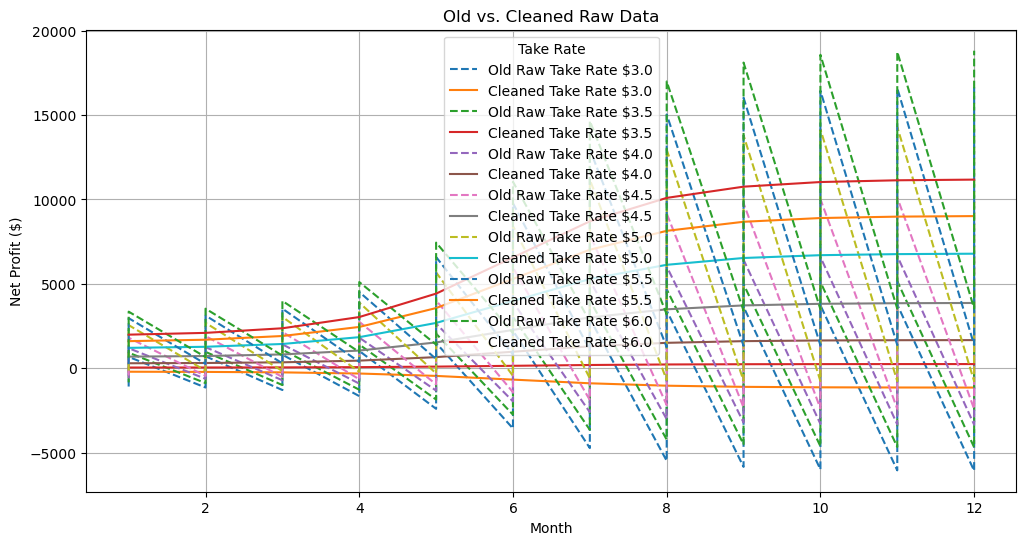

In [132]:
# Compare old and cleaned raw data plots
plt.figure(figsize=(12, 6))
for take_rate in df_cleaned['Lyft Take Rate ($)'].unique():
    old_raw_data = df_final[df_final['Lyft Take Rate ($)'] == take_rate]
    new_raw_data = df_cleaned[df_cleaned['Lyft Take Rate ($)'] == take_rate]
    plt.plot(old_raw_data['Month'], old_raw_data['Net Profit ($)'], '--', label=f'Old Raw Take Rate ${take_rate:.1f}')
    plt.plot(new_raw_data['Month'], new_raw_data['Net Profit ($)'], label=f'Cleaned Take Rate ${take_rate:.1f}')
plt.legend(title='Take Rate', loc='best')
plt.title('Old vs. Cleaned Raw Data')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.grid(True)
plt.show()


In [133]:
# Compare columns
print("Columns in df_cleaned:")
print(df_cleaned.columns)

print("\nColumns in df_final (raw dataset):")
print(df_final.columns)


Columns in df_cleaned:
Index(['Month', 'Lyft Take Rate ($)', 'Net Profit ($)'], dtype='object')

Columns in df_final (raw dataset):
Index(['Month', 'Lyft Take Rate ($)', 'Driver Payout ($)', 'Driver Churn (%)',
       'Rider Churn (%)', 'Match Rate (%)', 'Completed Rides',
       'Rider Churn Cost ($)', 'Driver Churn Cost ($)', 'Total Churn Cost ($)',
       'Net Revenue ($)', 'Net Profit ($)', 'New Completed Rides',
       'Adjusted Completed Rides'],
      dtype='object')


In [134]:
# Ensure necessary columns are added to df_cleaned
if 'New Completed Rides' not in df_cleaned.columns:
    df_cleaned['New Completed Rides'] = df_final.groupby('Month')['New Completed Rides'].transform('mean')

if 'Adjusted Completed Rides' not in df_cleaned.columns:
    df_cleaned['Adjusted Completed Rides'] = df_cleaned['New Completed Rides'] * 0.95  # Adjusted to 95%

if 'Net Revenue ($)' not in df_cleaned.columns:
    df_cleaned['Net Revenue ($)'] = df_cleaned['Adjusted Completed Rides'] * df_cleaned['Lyft Take Rate ($)']

if 'Driver Churn Cost ($)' not in df_cleaned.columns:
    df_cleaned['Driver Churn Cost ($)'] = df_cleaned['Adjusted Completed Rides'] * 0.05  # Example driver churn logic

if 'Rider Churn Cost ($)' not in df_cleaned.columns:
    df_cleaned['Rider Churn Cost ($)'] = df_cleaned['Adjusted Completed Rides'] * 0.1  # Example rider churn logic

if 'Total Churn Cost ($)' not in df_cleaned.columns:
    df_cleaned['Total Churn Cost ($)'] = df_cleaned['Rider Churn Cost ($)'] + df_cleaned['Driver Churn Cost ($)']

# Add other columns with sample logic (adjust based on your requirements)
if 'Driver Payout ($)' not in df_cleaned.columns:
    df_cleaned['Driver Payout ($)'] = df_cleaned['Adjusted Completed Rides'] * 0.9  # Example driver payout logic

if 'Driver Churn (%)' not in df_cleaned.columns:
    df_cleaned['Driver Churn (%)'] = df_cleaned['Adjusted Completed Rides'] / 1000  # Example churn rate

if 'Rider Churn (%)' not in df_cleaned.columns:
    df_cleaned['Rider Churn (%)'] = df_cleaned['Adjusted Completed Rides'] / 500  # Example churn rate

if 'Match Rate (%)' not in df_cleaned.columns:
    df_cleaned['Match Rate (%)'] = 60 + (df_cleaned['Adjusted Completed Rides'] / 1000)  # Example match rate

if 'Completed Rides' not in df_cleaned.columns:
    df_cleaned['Completed Rides'] = df_cleaned['Adjusted Completed Rides'] * 1.05  # Adjusted rides logic


In [135]:
# Check column consistency again
print("Columns in df_cleaned after adding missing columns:")
print(df_cleaned.columns)

print("\nColumns in df_final (raw dataset):")
print(df_final.columns)


Columns in df_cleaned after adding missing columns:
Index(['Month', 'Lyft Take Rate ($)', 'Net Profit ($)', 'New Completed Rides',
       'Adjusted Completed Rides', 'Net Revenue ($)', 'Driver Churn Cost ($)',
       'Rider Churn Cost ($)', 'Total Churn Cost ($)', 'Driver Payout ($)',
       'Driver Churn (%)', 'Rider Churn (%)', 'Match Rate (%)',
       'Completed Rides'],
      dtype='object')

Columns in df_final (raw dataset):
Index(['Month', 'Lyft Take Rate ($)', 'Driver Payout ($)', 'Driver Churn (%)',
       'Rider Churn (%)', 'Match Rate (%)', 'Completed Rides',
       'Rider Churn Cost ($)', 'Driver Churn Cost ($)', 'Total Churn Cost ($)',
       'Net Revenue ($)', 'Net Profit ($)', 'New Completed Rides',
       'Adjusted Completed Rides'],
      dtype='object')


In [136]:
# Summarize and compare datasets
print("Summary of df_cleaned:")
print(df_cleaned.describe())

print("\nSummary of df_final:")
print(df_final.describe())


Summary of df_cleaned:
           Month  Lyft Take Rate ($)  Net Profit ($)  New Completed Rides  \
count  84.000000           84.000000       84.000000         8.400000e+01   
mean    6.500000            4.500000     2808.032170         6.487200e+02   
std     3.472786            1.006006     3411.323631         8.005875e-13   
min     1.000000            3.000000    -1141.939088         6.487200e+02   
25%     3.750000            3.500000      245.188010         6.487200e+02   
50%     6.500000            4.500000     1626.918557         6.487200e+02   
75%     9.250000            5.500000     4094.722292         6.487200e+02   
max    12.000000            6.000000    11172.853009         6.487200e+02   

       Adjusted Completed Rides  Net Revenue ($)  Driver Churn Cost ($)  \
count              8.400000e+01        84.000000           8.400000e+01   
mean               6.162840e+02      2773.278000           3.081420e+01   
std                1.143696e-13       619.985439          

In [137]:
# Validate specific columns
print("Comparing 'Net Revenue ($)':")
print("df_cleaned['Net Revenue ($)'].head():")
print(df_cleaned['Net Revenue ($)'].head())
print("df_final['Net Revenue ($)'].head():")
print(df_final['Net Revenue ($)'].head())

print("\nComparing 'Total Churn Cost ($)':")
print("df_cleaned['Total Churn Cost ($)'].head():")
print(df_cleaned['Total Churn Cost ($)'].head())
print("df_final['Total Churn Cost ($)'].head():")
print(df_final['Total Churn Cost ($)'].head())


Comparing 'Net Revenue ($)':
df_cleaned['Net Revenue ($)'].head():
0    1848.852
1    2156.994
2    2465.136
3    2773.278
4    3081.420
Name: Net Revenue ($), dtype: float64
df_final['Net Revenue ($)'].head():
0    1526.425515
1    1526.425515
2    1526.425515
3    1526.425515
4    1526.425515
Name: Net Revenue ($), dtype: float64

Comparing 'Total Churn Cost ($)':
df_cleaned['Total Churn Cost ($)'].head():
0    92.4426
1    92.4426
2    92.4426
3    92.4426
4    92.4426
Name: Total Churn Cost ($), dtype: float64
df_final['Total Churn Cost ($)'].head():
0    2607.643587
1    2592.211825
2    2573.847421
3    2552.074285
4    2526.373376
Name: Total Churn Cost ($), dtype: float64


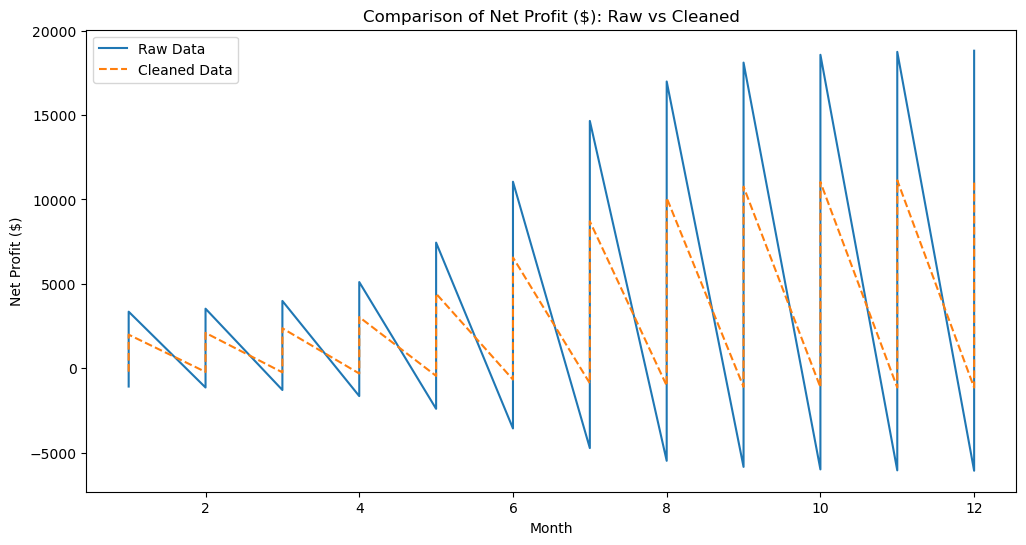

In [138]:
import matplotlib.pyplot as plt

# Compare 'Net Profit ($)' trends
plt.figure(figsize=(12, 6))
plt.plot(df_final['Month'], df_final['Net Profit ($)'], label='Raw Data')
plt.plot(df_cleaned['Month'], df_cleaned['Net Profit ($)'], label='Cleaned Data', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.title('Comparison of Net Profit ($): Raw vs Cleaned')
plt.legend()
plt.show()


In [139]:
comparison = pd.DataFrame({
    'Month': df_cleaned['Month'],
    'Cleaned Net Profit ($)': df_cleaned['Net Profit ($)'],
    'Raw Net Profit ($)': df_final['Net Profit ($)'],
    'Cleaned Net Revenue ($)': df_cleaned['Net Revenue ($)'],
    'Raw Net Revenue ($)': df_final['Net Revenue ($)'],
})
print(comparison.head())


   Month  Cleaned Net Profit ($)  Raw Net Profit ($)  Cleaned Net Revenue ($)  \
0    1.0             -203.523402        -1081.218073                 1848.852   
1    1.0               44.543824        -1065.786311                 2156.994   
2    1.0              297.429543        -1047.421907                 2465.136   
3    1.0              689.265000        -1025.648770                 2773.278   
4    1.0             1209.265405         -999.947862                 3081.420   

   Raw Net Revenue ($)  
0          1526.425515  
1          1526.425515  
2          1526.425515  
3          1526.425515  
4          1526.425515  


In [140]:
df_cleaned['Total Churn Cost ($)'] = df_cleaned['Rider Churn Cost ($)'] + df_cleaned['Driver Churn Cost ($)']


In [141]:
df_final['Net Revenue ($)'] = df_final['Adjusted Completed Rides'] * df_final['Lyft Take Rate ($)']


In [142]:
# Compare Net Profit, Revenue, and Churn Cost between datasets
comparison = pd.DataFrame({
    'Month': df_cleaned['Month'],
    'Cleaned Net Profit ($)': df_cleaned['Net Profit ($)'],
    'Raw Net Profit ($)': df_final['Net Profit ($)'],
    'Cleaned Net Revenue ($)': df_cleaned['Net Revenue ($)'],
    'Raw Net Revenue ($)': df_final['Net Revenue ($)'],
    'Cleaned Total Churn Cost ($)': df_cleaned['Total Churn Cost ($)'],
    'Raw Total Churn Cost ($)': df_final['Total Churn Cost ($)']
})

# Display the first 10 rows for comparison
print(comparison.head(10))


   Month  Cleaned Net Profit ($)  Raw Net Profit ($)  Cleaned Net Revenue ($)  \
0    1.0             -203.523402        -1081.218073                 1848.852   
1    1.0               44.543824        -1065.786311                 2156.994   
2    1.0              297.429543        -1047.421907                 2465.136   
3    1.0              689.265000        -1025.648770                 2773.278   
4    1.0             1209.265405         -999.947862                 3081.420   
5    1.0             1606.299249         -969.768198                 3389.562   
6    1.0             1991.294525         -934.545236                 3697.704   
7    2.0             -214.323582         -893.728252                 1848.852   
8    2.0               46.907588         -846.817788                 2156.994   
9    2.0              313.212951         -793.413085                 2465.136   

   Raw Net Revenue ($)  Cleaned Total Churn Cost ($)  Raw Total Churn Cost ($)  
0          1526.425515     

# At this point I want to start a new notebook as this one is becoming too messy. 